_______________________




# <span style="color:pink"> Trabajo Práctico 3 - Big Data </span>


_______________________

<span style="color:#581845">***Regularización aplicada a la EPH*** 
</span>


<span style="color:#C70039">Florencia Pucci, Abigail Riquelme, Judith Sardinas 
</span>


### Parte I: Análisis de la base de hogares y cálculo de pobreza

In [953]:
# Código para mostrar el codigo. La fuente es la siguiente: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer


import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

#### Importamos los módulos necesarios

In [570]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit
from sklearn.model_selection import KFold

#### Pasos previos 

In [571]:
# Definimos el directorio de trabajo 
directorio_tp="C:\\Users\\Abi\\Documents\\GitHub\\TrabajosPracticos-Grupo8\\TP2"

In [954]:
import os

# Modificamos el directorio de trabajo
os.chdir(directorio_tp) 

# Verificamos que el directorio sea el correcto
os.getcwd()

'C:\\Users\\Abi\\Documents\\GitHub\\TrabajosPracticos-Grupo8\\TP2'

##### 1) 

Consideramos que con el objetivo de predecir pobreza sería muy útil incluir variables
relacionadas a la infraestructura del hogar. Por ejemplo, podríamos tener en cuenta la
variable IV7, que indica con un valor de 1 si el agua del hogar es de red pública, con
un valor de 2 si es de perforación con bomba a motor y por último con un valor de 3
es de perforación con bomba manual. También podríamos utilizar la variable V4 que
informa sobre los materiales de la cubierta exterior del techo.
Siguiendo con las variables que son informativas sobre las características de la vivienda
podemos considerar a la variable II8 que da información sobre el combustible utilizado para cocinar. También podría ser valioso considerar a la variable IV12_3, esta
indica si la vivienda está ubicada en villa de emergencia (por observación).


En cuanto a las estrategias del hogar creemos que sería interesante considerar V5 que
nos indica si en los últimos tres meses las personas de este hogar han vivido de un
subsidio o ayuda social (en dinero) del gobierno, iglesias, etc. Con respecto a esto
también sería útil saber si los menores de edad ayudan con algún dinero trabajando,
debido a que si realizan esto puede estar indicando que la familia tiene necesidades
extremas que llevan a que los menores de edad trabajen o que no tienen información
correcta sobre los verdaderos retornos de la inversión en educación. Diversos autores
han estudiado las consecuencias psicológicas de la pobreza, en particular, los efectos
en la toma de riesgo. Esto también se puede ver reflejado en el nivel educativo de cada
persona, dicha información está contenida en la variable NIVEL_ED.
En On the Psychology of Poverty (Haushofer & Fehr, 2014) se plantea que las personas
que viven en la pobreza, especialmente en los países en desarrollo, son más reacias
al riesgo y tienen más probabilidades de no considerar los beneficios futuros que las
personas más ricas, es decir, tienen tasa de descuento más altas. Hay evidencia que
sugiere que la pobreza tiene un efecto causal en la toma de riesgos y el descuento del
tiempo.


Tanaka et.al (2010) realizan un estudio con datos de Vietnam, encuentran que las tasas de descuento medidas experimentalmente de los encuestados vietnamitas se relacionaron
negativamente con los ingresos; es decir, los hogares más pobres tenían más probabilidades de elegir recompensas monetarias más pequeñas y más tempranas que las más
grandes y demoradas. Es decir, los pobres tienen un deseo menor de tomar un riesgo
financiero y esto genera que se prevengan inversiones de largo plazo en, por ejemplo,
salud y educación.


Por último, consideramos que también sería interesante considerar variable que nos
den información sobre las características cuantitativas del hogar, por ejemplo, podría
ser útil considerar la cantidad de miembros del hogar menores de 10 años, debido a
que una de las características de los hogares más pobres es que la tasa de fecundidad
es mayor (Birdsall & Griffin, 1988). Esta información está contenida en la variable
IX_Men10 o en la variable IX_TOT. La primera indica la cantidad de menores de 10 años
que hay en el hogar y la segunda indica la cantidad de integrantes del hogar. 

#### 2) 

In [573]:
import pandas as pd
eph_2021=pd.read_excel('usu_hogar_T121.xlsx')

In [574]:
# Descarguen la base de microdatos de la EPH correspondiente al primer tri-
# mestre de 2021 (la base de hogares se llama usu_hogar_T121.xls). Importen
# los datos de la encuesta de hogar y al igual que en el TP1 conserven sólo las
# observaciones que corresponden a los aglomerados de Ciudad Autónoma
# de Buenos Aires o del Gran Buenos Aires.


# Abrimos la base de datos, la llamaremos eph_2021:
eph_2021=pd.read_excel('usu_hogar_T121.xlsx')

In [575]:
# Eliminamos todas las observaciones que no corresponden a los aglomerados de Ciu-
# dad Autónoma de Buenos Aires o Gran Buenos Aires.
eph_2021 = eph_2021[eph_2021.REGION == 1]

In [576]:
len(eph_2021)

1474

#### 3) 

In [577]:
# Unan la tabla de la encuesta individual con la de la encuesta de hogar.

# Para esto, importamos los datos de la encuesta individual. Abrimos la base de datos, la llamaremos eph_2021_ind:

eph_2021_ind = pd.read_excel('usu_individual_T121.xlsx')

In [578]:
len(eph_2021_ind)

46693

In [579]:
# Eliminamos todas las observaciones que no corresponden a los aglomerados de Ciu-
# dad Autónoma de Buenos Aires o Gran Buenos Aires.

eph_2021_ind = eph_2021_ind[eph_2021_ind.REGION == 1]

In [580]:
# Unimos la tabla de la encuesta individual con la de la encuesta de hogar 
eph_final = pd.merge(eph_2021_ind, eph_2021, how='left', on=['CODUSU', 'NRO_HOGAR'])

In [581]:
len(eph_final)

4082

#### 4) 

Con el objetivo de limpiar la base de datos utilizaremos las funciones SimpleImputer,
fit y transform para las variables no categóricas, todas disponibles en el paquete
sklearn.impute. La función fit lo que hace es coloque el imputador en la base a la
que le aplicamos la función y transform imputa todos los valores faltantes en la base
de datos.

Para las variables categóricas utilizaremos la función fillna y get_dummies, ambas del
paquete Pandas.


In [583]:
# Seteamos el código para que podamos observar todas las columnas cuando corramos el comango ".head()"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [584]:
# Observamos las primeras 20 filas de la matriz 

eph_final.head(20)

,CODUSU,ANO4_x,TRIMESTRE_x,NRO_HOGAR,COMPONENTE,H15,REGION_x,MAS_500_x,AGLOMERADO_x,PONDERA_x,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,ANO4_y,TRIMESTRE_y,REALIZADA,REGION_y,MAS_500_y,AGLOMERADO_y,PONDERA_y,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF_y,DECIFR_y,IDECIFR_y,RDECIFR_y,GDECIFR_y,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOPPRHKMLNCDEIIAD00655703,2021,1,1,1,1,1,S,32,1394,1,1,21/06/1991,29,1,1,1,2,0,7,1,NaN,1,NaN,1,NaN,6,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,24.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,6400.0,2.0,0.0,0.0,0.0,0.0,12.0,0.0,10331.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,70000.0,0.0,0.0,0.0,35000.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70000,9,NaN,9,9.0,NaN,8,1822,0,105000.0,10,NaN,10,10.0,NaN,9,1883,0,0,0,0,0,0,0,0,0,0,0,0,0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.00,10.0,0.0,10.0,10.0,0.0,10.0,2494,2021,1,1,1,S,32,1394,2,NaN,2,1,NaN,9,1,1,1,NaN,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,255000.0,10.0,NaN,10.0,10.0,NaN,10.0,127500.00,10.0,NaN,10.0,10.0,NaN,10.0,2494,1,2,98,0,0,0
1,TQRMNOPPRHKMLNCDEIIAD00655703,2021,1,1,2,1,1,S,32,1394,2,2,02/11/1991,29,1,1,1,2,0,7,1,NaN,1,NaN,1,NaN,6,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,42.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2709.0,2.0,0.0,0.0,0.0,0.0,99.0,9.0,30332.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,0.0,0.0,150000.0,0.0,0.0,0.0,0.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150000,10,NaN,10,10.0,NaN,10,1795,0,150000.0,10,NaN,10,10.0,NaN,10,1761,0,0,0,0,0,0,0,0,0,0,0,0,0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.00,10.0,0.0,10.0,10.0,0.0,10.0,2494,2021,1,1,1,S,32,1394,2,NaN,2,1,NaN,9,1,1,1,NaN,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,255000.0,10.0,NaN,10.0,10.0,NaN,10.0,127500.00,10.0,NaN,10.0,10.0,NaN,10.0,2494,1,2,98,0,0,0
2,TQRMNOPPWHKMNUCDEIIAD00655837,2021,1,1,1,1,1,S,32,3090,1,1,06/07/1966,54,2,1,1,2,0,7,1,NaN,3,26.0,1,NaN,6,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,40.0,0.0,2.0,0.0,2.0,1.0,2.0,2.0,6900.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,20331.0,6.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0,3.0,2.0,200000.0,0.0,0.0,0.0,0.0,0

In [585]:
# Observamos el tipo de cada columna de la matriz, es decir, de cada variable 
tipos=eph_final.dtypes

print(tipos)

CODUSU           object
ANO4_x            int64
TRIMESTRE_x       int64
NRO_HOGAR         int64
COMPONENTE        int64
H15               int64
REGION_x          int64
MAS_500_x        object
AGLOMERADO_x      int64
PONDERA_x         int64
CH03              int64
CH04              int64
CH05             object
CH06              int64
CH07              int64
CH08              int64
CH09              int64
CH10              int64
CH11              int64
CH12              int64
CH13              int64
CH14            float64
CH15              int64
CH15_COD        float64
CH16              int64
CH16_COD        float64
NIVEL_ED          int64
ESTADO            int64
CAT_OCUP          int64
CAT_INAC          int64
IMPUTA          float64
PP02C1            int64
PP02C2            int64
PP02C3            int64
PP02C4            int64
PP02C5            int64
PP02C6            int64
PP02C7            int64
PP02C8            int64
PP02E             int64
PP02H             int64
PP02I           

##### 5) 

En primer lugar, consideramos relevante eliminar aquellas variables que tienen un porcentaje de datos missing mayor al 80%. En la Tabla (1) presentamos dichas variables y
el porcentaje de datos missing correspondiente. La Figura (1) muestra la cantidad de
variables que tienen un porcentaje de datos missing mayor y menor al 80%. También faltantes
presentamos la Figura (2) que muestra el tipo de datos que tiene cada variable. Observamos que la mayoría de las variables son del tipo float64, luego le siguen las
variables de tipo int64 y por último tenemos un grupo más pequeño de variables de
tipo object.
Ahora bien, para el tratamiento de los datos missing de las variables restantes consideramos útil usar estrategias distintas para las variables categóricas y no categóricas. 


Es importante aclarar que separamos aquellas variables técnicas, es decir, aquellas que
son útiles para la identificación de los individuos, entre otras cuestiones. Luego del
tratamiento de variables categóricas y no categóricas volvimos a unificar la base de
datos.
Para tratar los missing de las variables categóricas los reemplazamos por cero, debido a
que creemos que la “no respuesta” de algunas preguntas puede ser un dato relevante.
Reemplazamos por este número debido a que ninguna variable categórica toma dicho
valor.
Además, decidimos crear variables dummies para cada uno de los valores de las variables categóricas, de esta forma será posible identificar distintos efectos según si las
variables dummies creadas tomar un valor de 0 o 1 y no si, por ejemplo, aumentan,
debido a que esto último no tiene un interpretación precisa.
Con respecto a las variables no categóricas lo que hicimos fue reemplazar los datos
missing con la media de cada variable. La forma en la que realizamos esto se específica
en las líneas de código correspondientes al punto 4.
Por último, unimos las bases de datos de las variables “técnicas” junto con las bases de
datos de variables categóricas y no categóricas sin datos faltantes y con las correspondientes transformaciones.
Ahora bien, para tratar de identificar los outliers de las variables no categóricas lo que
hicimos fue, en primer lugar, graficar las distribuciones de dichas variables (Ver Online
Appendix).
Posteriormente nos quedamos con aquellas observaciones que se encuentran entre el
quantil 0.99 y el 0.01. Al hacer esto, el total de observaciones eliminadas fue de 765.
Estas observaciones, según el criterio utilizado, son outliers. De esta forma, nos quedan
un total de 3317 observaciones.

In [586]:
# Con el objetivo de visualizar la cantidad de variables según el tipo de datos que contienen realizamos el siguiente gráfico:

tipos_df=pd.DataFrame(tipos)

In [939]:
tipos_df.head()

,0
CODUSU,object
ANO4_x,int64
TRIMESTRE_x,int64
NRO_HOGAR,int64
COMPONENTE,int64


Figura 1 

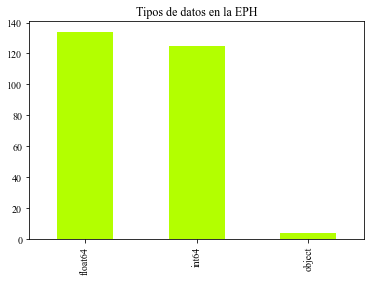

In [938]:
# Seteamos la fuente de los gráficos 
plt.rcParams["font.family"] = "Times New Roman"

plot = tipos_df[0].value_counts().plot(kind='bar',
                                            title='Tipos de datos en la EPH',color=(0.7,1,0))

# Exportamos el gráfico en formato eps 

plt.savefig('TypesData.eps', format='eps')

Tabla 1

In [589]:
# calculamos el porcentaje de missings que tienen cada variable de la base de datos eph_final

na_ratio = ((eph_final.isnull().sum() / len(eph_final))*100).sort_values(ascending = False)
print(na_ratio)


IDECOCUR        100.000000
IDECIFR_y       100.000000
PP09C_ESP       100.000000
PP09A_ESP       100.000000
IDECCFR_y       100.000000
PDECOCUR        100.000000
PDECCFR_y       100.000000
IDECINDR        100.000000
II8_ESP         100.000000
PDECINDR        100.000000
II7_ESP         100.000000
IV7_ESP         100.000000
IV3_ESP         100.000000
IV1_ESP         100.000000
PDECIFR_y       100.000000
IMPUTA           99.240568
CH16_COD         99.020088
PP11D_COD        95.957864
PP11C            94.781970
PP11C99          94.781970
PP11B2_DIA       94.781970
PP11B2_MES       94.781970
PP11B2_ANO       94.781970
PP11T            94.781970
PP11B_COD        94.781970
PP11A            94.781970
PP10E            94.781970
PP10D            94.781970
PP10C            94.781970
PP10A            94.781970
PP11B1           94.781970
PP11G_ANO        94.781970
PP11N            94.781970
PP11G_MES        94.781970
PP11S            94.781970
PP11R            94.781970
PP11Q            94.781970
P

In [590]:
na_ratio_df=pd.DataFrame(na_ratio)
na_ratio_df.head()



,0
IDECOCUR,100.0
IDECIFR_y,100.0
PP09C_ESP,100.0
PP09A_ESP,100.0
IDECCFR_y,100.0


In [940]:
lista_condiciones = [ 
    (na_ratio_df[0]>80), 
    (na_ratio_df[0]==80), 
    (na_ratio_df[0]<80)]
# a continuación definimos una lista de valores
lista_valores = [1,0,0] 

# ahora utilizaremos la función np.select. Ahora es cuando utilizamos la lista_condiciones y lista valores 
# para aplicar los valores correspondientes a aquellas variables que cumplan determinadas condiciones

na_ratio_df['porcentajeM']=np.select(lista_condiciones, lista_valores, default="No especificado") 

Figura 2 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


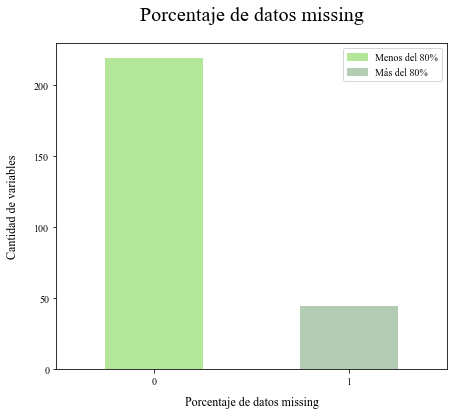

In [592]:
na_ratio_df['porcentajeM'].value_counts().plot(kind='bar', color=((0.7,0.9,0.6), (0.7,0.8,0.7)),figsize=(7, 6), rot=0)
plt.xlabel('Porcentaje de datos missing',labelpad=10,fontsize='12')
plt.ylabel('Cantidad de variables',labelpad=15, fontsize='12')
plt.title('Porcentaje de datos missing', y=1.05, fontsize='20')
colors ={'Menos del 80%':(0.7,0.9,0.6),'Más del 80%':(0.7,0.8,0.7)}
labels = list(colors.keys())
handles = [plt.Rectangle((1,1),0.5,0.5, color=colors[label]) for label in labels]
plt.legend(handles, labels)

# Guardamos el gráfico: 
plt.savefig('PorcentajeM.eps', format='eps')


# otros colores 0.7/0.9/0.1     0.7/1/0.5    0.7/0.8/0.4

###### Tratamiento de los missings de variables categóricas 

In [593]:
# Para tratar los missing de las variables categóricas les asignaremos un valor igual a -1 para de esta forma 
# tener información sobre las personas que no respondieron. Decidimos seguir este enfoque debido a que 
# en algunos casos puede ser útil contar con dicha información. 



In [594]:
# Es importante aclarar que aquellas variables más técnicas, es decir, aquellas que nos permiten identificar a los hogares las pondremos, por el momento, en un base de datos aparte. Luego, 
# uniremos las bases de datos con variables categóricas, no categóricas junto con la base de datos de variables técnicas: 

eph_tecnicas=eph_final.loc[:,['TRIMESTRE_x', 'NRO_HOGAR','CODUSU', 'COMPONENTE', 'H15', 'REGION_x', 'AGLOMERADO_x', 'PONDERA_x']]

In [595]:
# Además, para tratar los missing de las variables categóricas eliminamos las variables no categóricas. 
# Posterior a esto uniremos las dos bases resultantes del tratado de los datos missing. Notar que a continuación eliminamos todas las variables no categóricas y además 
# aquellas categóricas que tienen un porcentaje de datos missing mayor al 80%.

eph_categoricas= eph_final.drop(['CODUSU', 'CH05','MAS_500_x','ANO4_x','MAS_500_y','IDECOCUR',    
'IDECIFR_y',    
'PP09C_ESP',    
'PP09A_ESP',    
'IDECCFR_y',    
'PDECOCUR',    
'PDECCFR_y',    
'IDECINDR',    
'II8_ESP',    
'PDECINDR',    
'II7_ESP',    
'IV7_ESP',    
'IV3_ESP',    
'IV1_ESP',    
'PDECIFR_y',    
'IMPUTA',    
'CH16_COD',    
'PP11D_COD',    
'PP11C',    
'PP11C99',    
'PP11B2_DIA',    
'PP11B2_MES',    
'PP11B2_ANO',    
'PP11T',    
'PP11B_COD',    
'PP11A',    
'PP10E',    
'PP10D',    
'PP10C',    
'PP10A',    
'PP11B1',    
'PP11G_ANO',    
'PP11N',    
'PP11G_MES',    
'PP11S',    
'PP11R',    
'PP11Q',    
'PP11P',    
'PP11O',    
'PP11M',    
'PP11L1',    
'PP11L',    
'PP11G_DIA',    
'CH15_COD','PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP04B2', 'PP06C', 'PP06D', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 
                                    'PP08J1', 
'PP08J2', 'PP08J3', 'P21', 'DECOCUR','RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'PONDIIO', 'TOT_P12', 
'P47T', 'DECINDR', 'RDECINDR', 'GDECINDR', 'ADECINDR', 'PONDII', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 
'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'ITF_x', 'DECIFR_x', 'IDECIFR_x', 'RDECIFR_x', 'GDECIFR_x', 
'PDECIFR_x', 'ADECIFR_x','IPCF_x', 'DECCFR_x', 'IDECCFR_x', 'RDECCFR_x', 'GDECCFR_x', 'PDECCFR_x', 'ADECCFR_x', 'PONDIH_x','REALIZADA','REGION_y', 'AGLOMERADO_y', 'PONDERA_y','ANO4_y','TRIMESTRE_y','ITF_y','DECIFR_y','RDECIFR_y','GDECIFR_y','ADECIFR_y','IPCF_y','DECCFR_y','RDECCFR_y','GDECCFR_y','ADECCFR_y','PONDIH_y','TRIMESTRE_x', 'NRO_HOGAR', 'COMPONENTE', 'H15', 'REGION_x', 'AGLOMERADO_x', 'PONDERA_x','PP04D_COD','PP04B_COD','CH06'], axis=1)


In [596]:
eph_categoricas.head(10)

,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,1,1,1,2,0,7,1,NaN,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
1,2,2,1,1,1,2,0,7,1,NaN,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,99.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
2,1,1,2,1,1,2,0,7,1,NaN,3,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
3,2,2,2,1,1,2,0,7,1,NaN,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
4,3,2,5,1,1,1,1,7,2,2.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
5,3,1,5,1,1,1,1,7,2,0.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
6,3,1,5,1,1,1,2,4,2,1.0,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
7,1,1,2,1,1,2,0,7,2,4.0,1,1,5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,0.0,2.0,2.0,4.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,9.0,4.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,1.0,4.0,1.0,0.0,0.0,2,3,1,9,1,1,1,1,1,1,1,2,2,2,3,1,2,0,1,2,2,2,0,2,0,1,1,1,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,1,2,98,0,0,0
8,2,2,2,1,1,2,0,6,1,NaN,1,1,6,3,0,1,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,1,9,1,1,1,1,1,1,1,2,2,2,3,1,2,0,1,2,

In [597]:
# Ahora reemplazamos los datos missing de la sub base de datos llamada eph_corr con un valor igual a 0. Elegimos este número 
# debido a que ninguna de las variables categóricas toma dicho valor. 

eph_categoricas=eph_categoricas.fillna(0)



In [598]:
# Observamor las primeras 20 observaciones de la base de variables categóricas con los missings corregidos (reemplazados por cero)

eph_categoricas.head(20)

,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,1,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
1,2,2,1,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,99.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
2,1,1,2,1,1,2,0,7,1,0.0,3,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
3,2,2,2,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
4,3,2,5,1,1,1,1,7,2,2.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
5,3,1,5,1,1,1,1,7,2,0.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
6,3,1,5,1,1,1,2,4,2,1.0,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
7,1,1,2,1,1,2,0,7,2,4.0,1,1,5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,0.0,2.0,2.0,4.0,2.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,9.0,4.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,1.0,4.0,1.0,0.0,0.0,2,3,1,9,1,1,1,1,1,1,1,2,2,2,3,1,2,0,1,2,2,2,0,2,0,1,1,1,2,1,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,1,2,98,0,0,0
8,2,2,2,1,1,2,0,6,1,0.0,1,1,6,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,1,9,1,1,1,1,1,1,1,2,2,2,3,1,2,0,1,2,

In [599]:
pd.options.display.max_seq_items = None


In [600]:
cols_eph_categoricas = eph_categoricas.columns.tolist()

cols_eph_categoricas


['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_

###### Tratamiento de los missings de variable no categóricas 

In [601]:
# A las variables no categóricas que tienen datos missing las reemplazaremos con la media 
# de cada variable. 

# Por lo tanto, definimos el miss_mean_imputer, que luego será de utilizar al las funciones .fit y .transform 

miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Hay 4 variables no categóricas que no consideraremos, debido a que 
# el porcentaje de datos missing es mayor al 80%. Estas son PDECOCUR, PDECINDR, IDECINDR, IDECOCUR.     

eph_no_categoricas=eph_final.loc[:,['CH06','PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP04B2', 'PP06C', 'PP06D', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 
                                    'PP08J1', 
'PP08J2', 'PP08J3', 'P21', 'DECOCUR','RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'PONDIIO', 'TOT_P12', 
'P47T', 'DECINDR', 'RDECINDR', 'GDECINDR', 'ADECINDR', 'PONDII', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 
'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI', 'ITF_x', 'DECIFR_x', 'IDECIFR_x', 'RDECIFR_x', 'GDECIFR_x', 
'PDECIFR_x', 'ADECIFR_x','IPCF_x', 'DECCFR_x', 'IDECCFR_x', 'RDECCFR_x', 'GDECCFR_x', 'PDECCFR_x', 'ADECCFR_x', 'PONDIH_x']]






In [602]:
# Observamos el porcentaje de datos missing que tiene cada variable no categórica 

na_ratio = ((eph_no_categoricas.isnull().sum() / len(eph_no_categoricas))*100).sort_values(ascending = False)
print(na_ratio)

PP08J1       57.447330
PP08D1       57.447330
PP03D        57.447330
PP08J3       57.447330
PP08J2       57.447330
PP08F2       57.447330
PP08F1       57.447330
PP08D4       57.447330
PP06D        57.447330
PP06C        57.447330
PP04B2       57.447330
PP3F_TOT     57.447330
PP3E_TOT     57.447330
P47T          0.563449
ITF_x         0.000000
IDECIFR_x     0.000000
DECIFR_x      0.000000
CH06          0.000000
T_VI          0.000000
V21_M         0.000000
V19_AM        0.000000
GDECIFR_x     0.000000
RDECIFR_x     0.000000
RDECCFR_x     0.000000
PDECIFR_x     0.000000
ADECIFR_x     0.000000
IPCF_x        0.000000
DECCFR_x      0.000000
IDECCFR_x     0.000000
V12_M         0.000000
GDECCFR_x     0.000000
PDECCFR_x     0.000000
ADECCFR_x     0.000000
V18_M         0.000000
V2_M          0.000000
V11_M         0.000000
V10_M         0.000000
P21           0.000000
DECOCUR       0.000000
RDECOCUR      0.000000
GDECOCUR      0.000000
ADECOCUR      0.000000
PONDIIO       0.000000
TOT_P12    

In [603]:
# Guardamos los nombres de las columnas para luego agregarlos a la matriz 

cols_eph_no_categoricas = eph_no_categoricas.columns.tolist()

cols_eph_no_categoricas



['CH06',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP04B2',
 'PP06C',
 'PP06D',
 'PP08D1',
 'PP08D4',
 'PP08F1',
 'PP08F2',
 'PP08J1',
 'PP08J2',
 'PP08J3',
 'P21',
 'DECOCUR',
 'RDECOCUR',
 'GDECOCUR',
 'ADECOCUR',
 'PONDIIO',
 'TOT_P12',
 'P47T',
 'DECINDR',
 'RDECINDR',
 'GDECINDR',
 'ADECINDR',
 'PONDII',
 'V2_M',
 'V3_M',
 'V4_M',
 'V5_M',
 'V8_M',
 'V9_M',
 'V10_M',
 'V11_M',
 'V12_M',
 'V18_M',
 'V19_AM',
 'V21_M',
 'T_VI',
 'ITF_x',
 'DECIFR_x',
 'IDECIFR_x',
 'RDECIFR_x',
 'GDECIFR_x',
 'PDECIFR_x',
 'ADECIFR_x',
 'IPCF_x',
 'DECCFR_x',
 'IDECCFR_x',
 'RDECCFR_x',
 'GDECCFR_x',
 'PDECCFR_x',
 'ADECCFR_x',
 'PONDIH_x']

In [604]:
# chequeamos la longitud de los nombres de las columnas de nuestra sub base de variables no categóricas 

len(cols_eph_no_categoricas)

55

In [605]:
# A continuación reemplazamos los datos missing con el promedio para las variables categóricas 


miss_mean_imputer = miss_mean_imputer.fit(eph_no_categoricas)




In [606]:
imputed_eph_final = miss_mean_imputer.transform(eph_no_categoricas.values)

In [607]:
imputed_eph_final.shape

(4082, 55)

In [608]:
print(imputed_eph_final)

[[2.90000000e+01 0.00000000e+00 2.40000000e+01 ... 0.00000000e+00
  1.00000000e+01 2.49400000e+03]
 [2.90000000e+01 0.00000000e+00 4.20000000e+01 ... 0.00000000e+00
  1.00000000e+01 2.49400000e+03]
 [5.40000000e+01 0.00000000e+00 4.00000000e+01 ... 0.00000000e+00
  1.20000000e+01 0.00000000e+00]
 ...
 [7.00000000e+01 1.72711572e-01 3.80518135e+01 ... 0.00000000e+00
  1.00000000e+00 3.65400000e+03]
 [1.50000000e+01 1.72711572e-01 3.80518135e+01 ... 0.00000000e+00
  1.00000000e+00 3.65400000e+03]
 [7.20000000e+01 1.72711572e-01 3.80518135e+01 ... 0.00000000e+00
  7.00000000e+00 1.66600000e+03]]


In [609]:
#eph_corr_final=pd.DataFrame(imputed_eph_final)

eph_no_categoricas=pd.DataFrame(imputed_eph_final, columns=cols_eph_no_categoricas)

In [610]:
eph_no_categoricas.head(30)

,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x
0,29.0,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,70000.000000,0.0,0.000000,0.000000,35000.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,1822.0,0.0,105000.0,10.0,10.0,10.0,9.0,1883.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.00,10.0,0.0,10.0,10.0,0.0,10.0,2494.0
1,29.0,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,150000.000000,0.000000,0.000000,0.000000,0.000000,150000.0,10.0,10.0,10.0,10.0,1795.0,0.0,150000.0,10.0,10.0,10.0,10.0,1761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.00,10.0,0.0,10.0,10.0,0.0,10.0,2494.0
2,54.0,0.000000,40.000000,0.000000,0.000000,200000.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,200000.0,10.0,10.0,10.0,10.0,4073.0,0.0,-9.0,12.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
3,53.0,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,180000.000000,0.0,0.000000,0.000000,90000.000000,0.000000,0.000000,180000.0,10.0,10.0,10.0,10.0,3946.0,0.0,270000.0,10.0,10.0,10.0,10.0,3903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
4,22.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
5,19.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
6,13.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
7,75.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-9.0,12.0,12.0,12.0,12.0,0.0,0.0,-9.0,12.0,12.0,12.0,12.0,0.0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25000.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
8,76.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3308.0,0.0,19000.0,3.0,3.0,3.0,2.0,4329.0,19000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19000.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.00,12.0,0.0,12.0,12.0,0.0,12.0,0.0
9,66.0,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,84000.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,84000.0,10.0,10.0,10.0,8.0,5242.0,0.0,84000.0,9.0,9.0,9.0,8.0,5355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130000.0,9.0,0.0,9.0,9.0,0.0,8.0,43333.33,8.0,0.0,8.0,8.0,0.0,6.0,7389.0


## Unimos el data frame de las variables categóricas y no categóricas:



In [611]:
eph_completa=pd.concat([eph_tecnicas,eph_no_categoricas,eph_categoricas], axis=1)

In [612]:
eph_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,1,1,1,32,1394,29.0,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,70000.000000,0.0,0.000000,0.000000,35000.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,1822.0,0.0,105000.0,10.0,10.0,10.0,9.0,1883.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.0,10.0,0.0,10.0,10.0,0.0,10.0,2494.0,1,1,1,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
1,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,2,1,1,32,1394,29.0,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,150000.000000,0.000000,0.000000,0.000000,0.000000,150000.0,10.0,10.0,10.0,10.0,1795.0,0.0,150000.0,10.0,10.0,10.0,10.0,1761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.0,10.0,0.0,10.0,10.0,0.0,10.0,2494.0,2,2,1,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,99.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
2,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,1,1,1,32,3090,54.0,0.000000,40.000000,0.000000,0.000000,200000.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,200000.0,10.0,10.0,10.0,10.0,4073.0,0.0,-9.0,12.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,0.0,0.0,0.0,0.0,-9.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,1,1,2,1,1,2,0,7,1,0.0,3,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
3,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,2,1,1,32,3090,53.0,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,180000.000000,0.0,0.000000,0.000000,90000.000000,0.000000,0.000000,180000.0,10.0,10.0,10.0,10.0,3946.0,0.0,270000.0,10.0,10.0,10.0,10.0,3903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,2,2,2,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,

#### Outliers 

In [613]:
# Para el tratamiento de los outliers lo que haremos es quedarnos con las observaciones que están dentro de los quantiles 0.99 y 0.01. De esta forma, 
# eliminamos los outliers. 
# Es importante aclarar que solo tiene sentido eliminar outliers de aquellas variables que no son categóricas. Ahora bien, 
# antes de aplicar el filtro por quantiles consideramos relevante realizar gráficos sobre las distribuciones de las variables no categóricas: 


C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

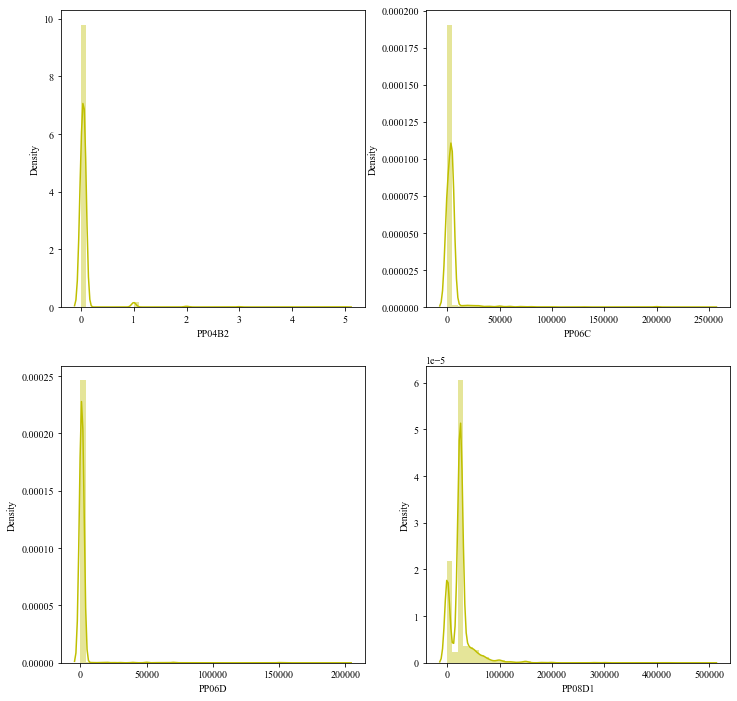

In [614]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)

sns.distplot(eph_completa['PP04B2'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['PP06C'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['PP06D'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['PP08D1'], ax=ax[1,1],color="y")

plt.savefig('Histo1.eps', format='eps')



C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function an

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

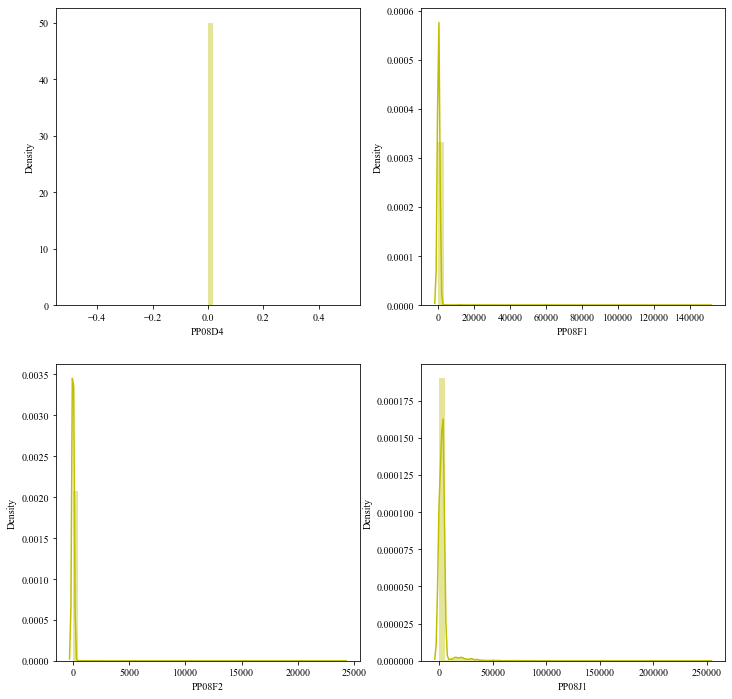

In [615]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)


sns.distplot(eph_completa['PP08D4'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['PP08F1'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['PP08F2'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['PP08J1'], ax=ax[1,1],color="y")

plt.savefig('Histo2.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

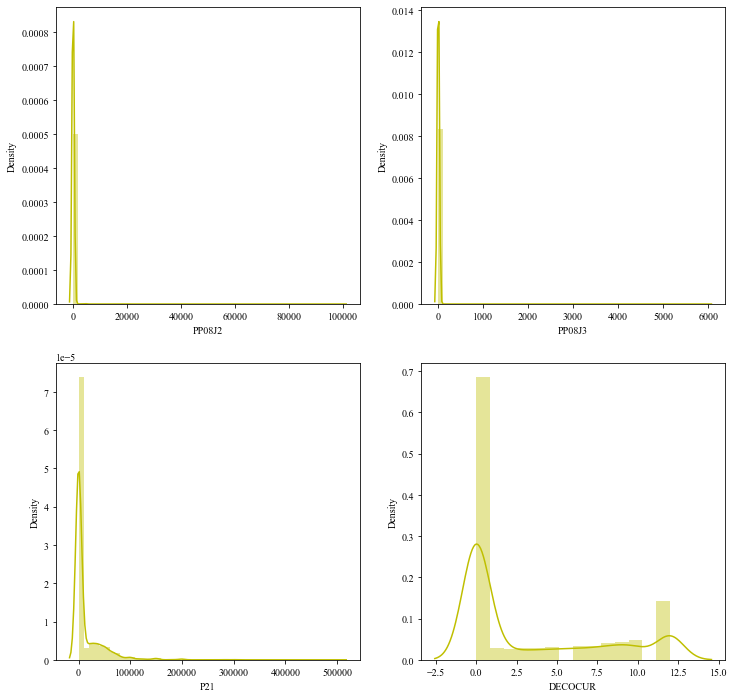

In [616]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)


sns.distplot(eph_completa['PP08J2'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['PP08J3'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['P21'],    ax=ax[1,0],color="y")
sns.distplot(eph_completa['DECOCUR'],ax=ax[1,1],color="y")

plt.savefig('Histo3.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

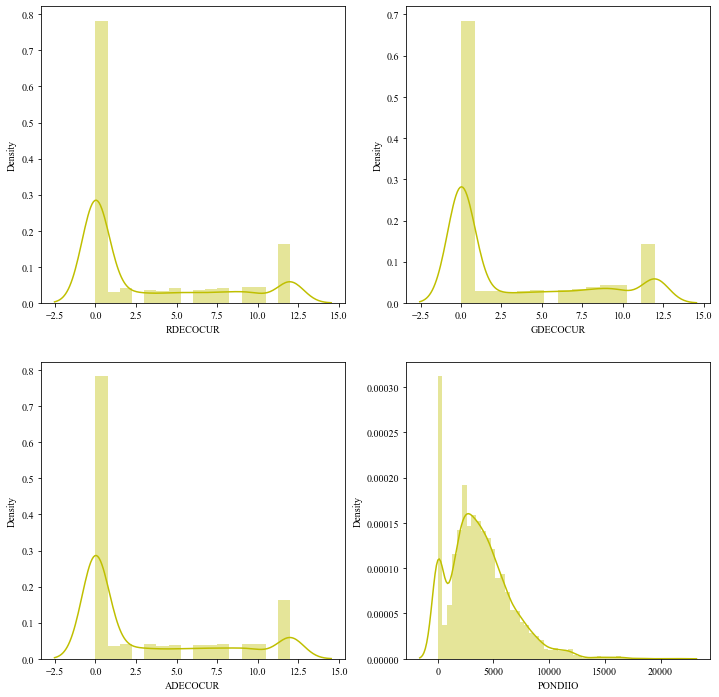

In [617]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)



sns.distplot(eph_completa['RDECOCUR'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['GDECOCUR'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['ADECOCUR'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['PONDIIO'],  ax=ax[1,1],color="y")

plt.savefig('Histo4.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

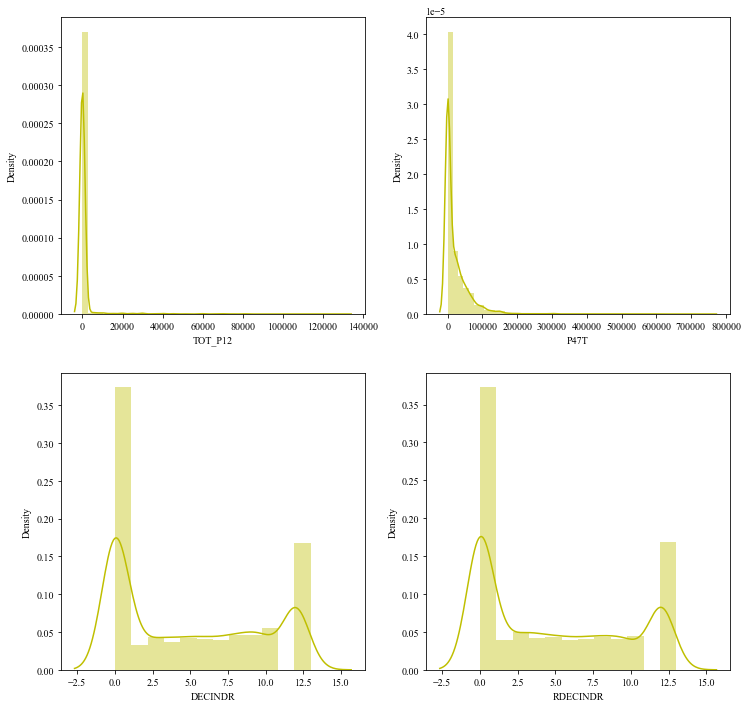

In [618]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)


sns.distplot(eph_completa['TOT_P12'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['P47T'],    ax=ax[0,1],color="y")
sns.distplot(eph_completa['DECINDR'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['RDECINDR'],ax=ax[1,1],color="y")

plt.savefig('Histo5.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

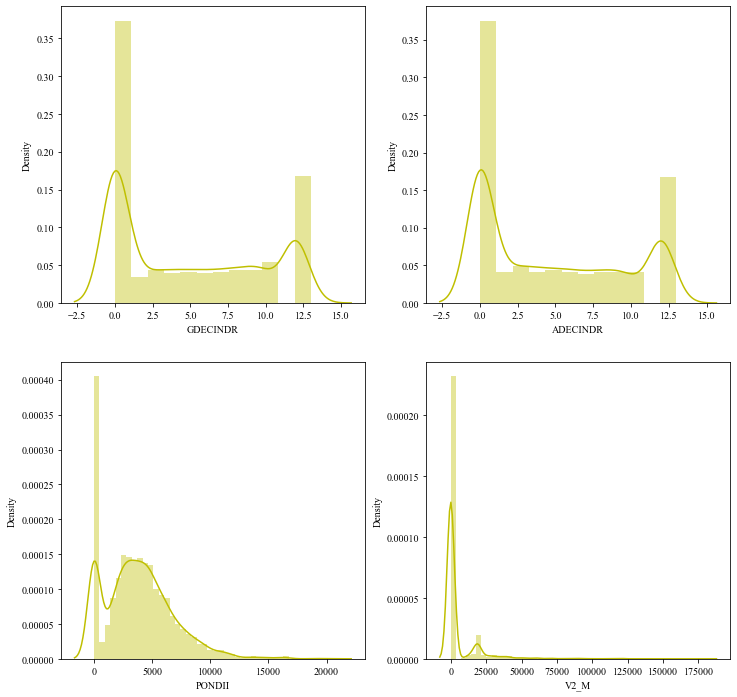

In [619]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)



sns.distplot(eph_completa['GDECINDR'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['ADECINDR'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['PONDII'],   ax=ax[1,0],color="y")
sns.distplot(eph_completa['V2_M'],     ax=ax[1,1],color="y")


plt.savefig('Histo6.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

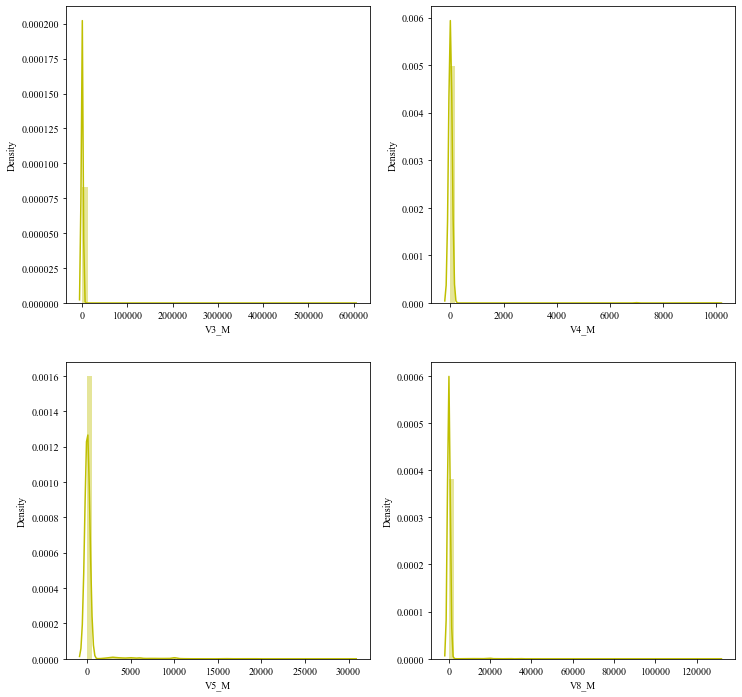

In [620]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)


sns.distplot(eph_completa['V3_M'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['V4_M'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['V5_M'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['V8_M'], ax=ax[1,1],color="y")

plt.savefig('Histo7.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

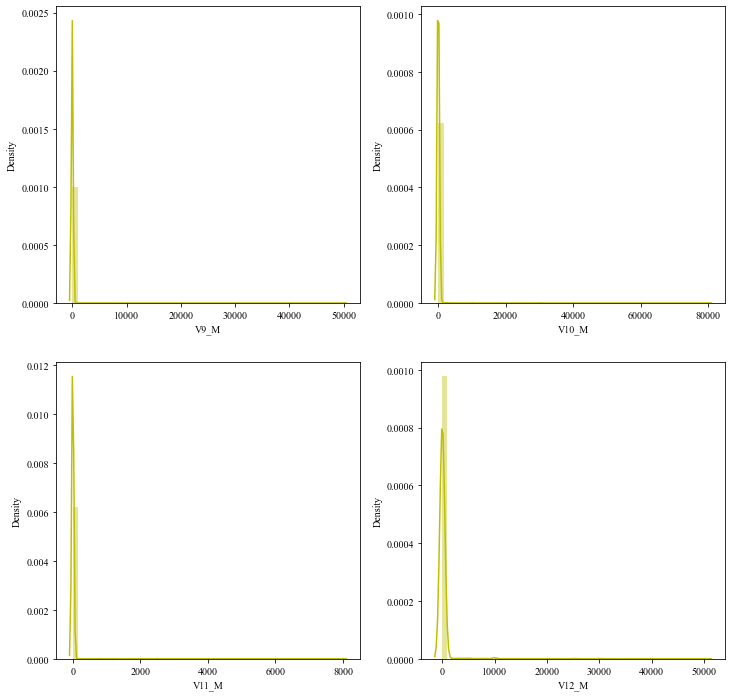

In [621]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)

sns.distplot(eph_completa['V9_M'],  ax=ax[0,0],color="y")
sns.distplot(eph_completa['V10_M'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['V11_M'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['V12_M'], ax=ax[1,1],color="y")

plt.savefig('Histo8.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function an

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

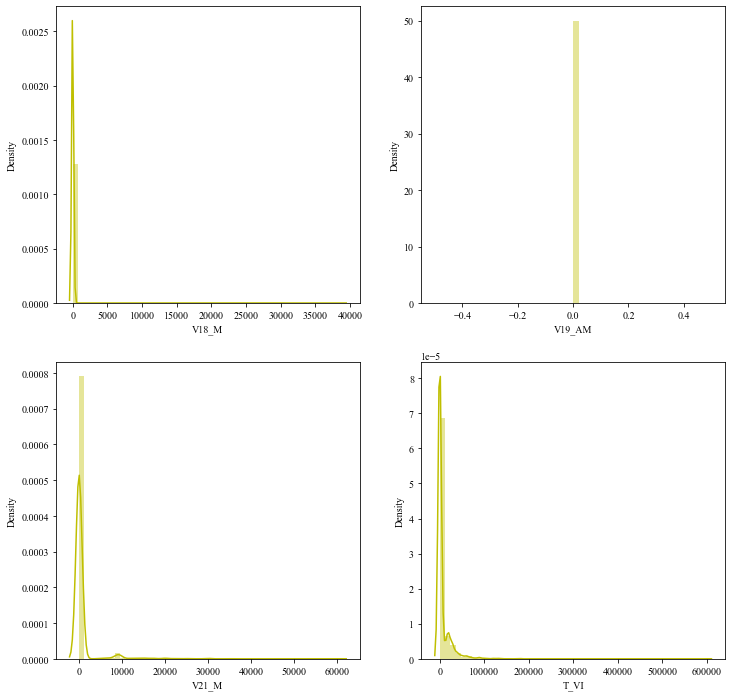

In [622]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)



sns.distplot(eph_completa['V18_M'],  ax=ax[0,0],color="y")
sns.distplot(eph_completa['V19_AM'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['V21_M'],  ax=ax[1,0],color="y")
sns.distplot(eph_completa['T_VI'],   ax=ax[1,1],color="y")

plt.savefig('Histo9.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

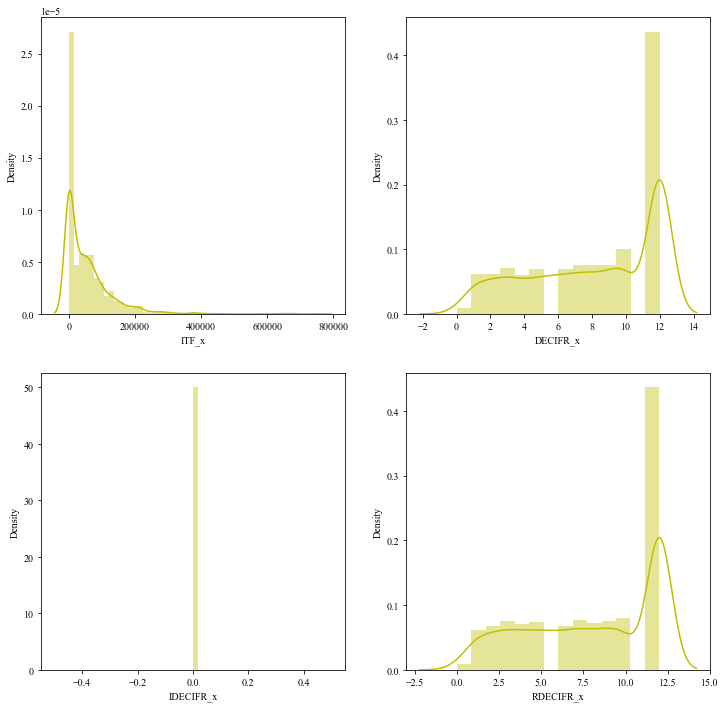

In [623]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)

'ITF_x', 'DECIFR_x', 'IDECIFR_x', 'RDECIFR_x',


sns.distplot(eph_completa['ITF_x'],    ax=ax[0,0],color="y")
sns.distplot(eph_completa['DECIFR_x'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['IDECIFR_x'],ax=ax[1,0],color="y")
sns.distplot(eph_completa['RDECIFR_x'],ax=ax[1,1],color="y")

plt.savefig('Histo10.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function an

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

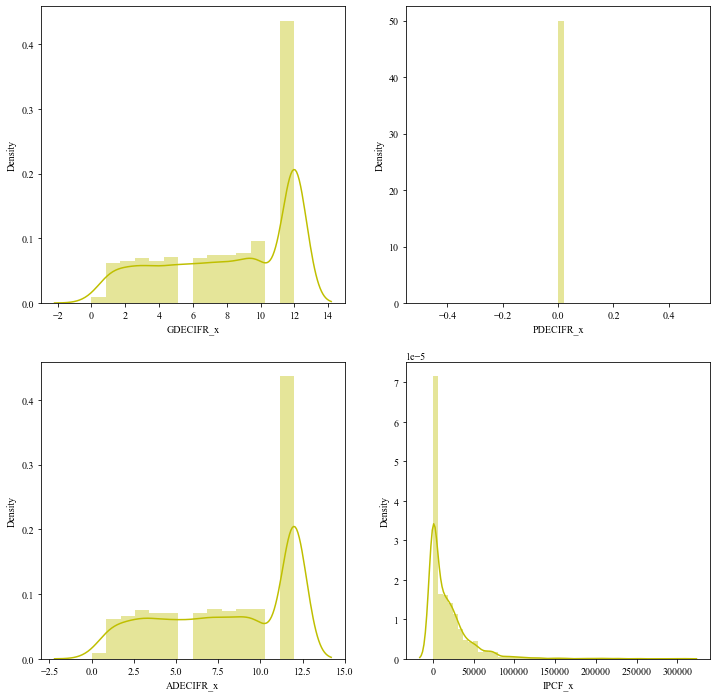

In [624]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)

'GDECIFR_x', 'PDECIFR_x', 'ADECIFR_x','IPCF_x', 


sns.distplot(eph_completa['GDECIFR_x'], ax=ax[0,0],color="y")
sns.distplot(eph_completa['PDECIFR_x'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['ADECIFR_x'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['IPCF_x'],    ax=ax[1,1],color="y")

plt.savefig('Histo11.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function an

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

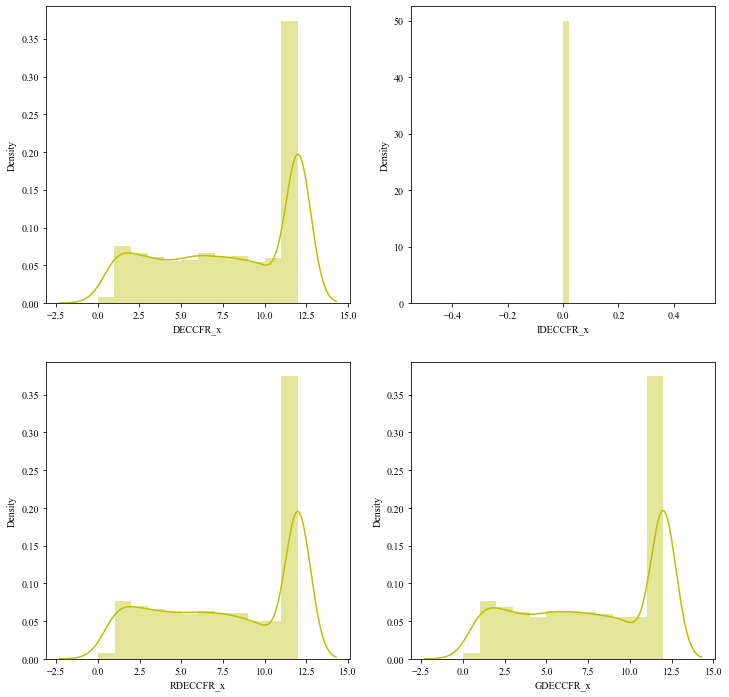

In [625]:
fig, ax= plt.subplots(2,2)

fig.set_size_inches(12,12)

sns.distplot(eph_completa['DECCFR_x'],  ax=ax[0,0],color="y")
sns.distplot(eph_completa['IDECCFR_x'], ax=ax[0,1],color="y")
sns.distplot(eph_completa['RDECCFR_x'], ax=ax[1,0],color="y")
sns.distplot(eph_completa['GDECCFR_x'], ax=ax[1,1],color="y")

plt.savefig('Histo12.eps', format='eps')




C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support tr

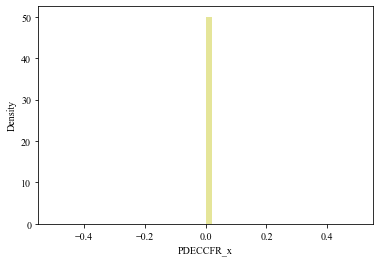

In [626]:



sns.distplot(eph_completa['PDECCFR_x'],color="y")


plt.savefig('Histo13.eps', format='eps')






C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered o

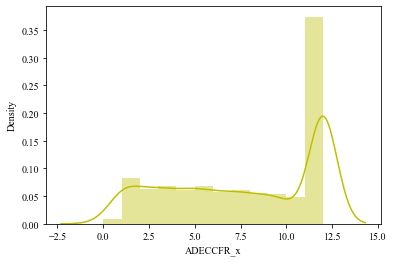

In [627]:
sns.distplot(eph_completa['ADECCFR_x'],color="y")

plt.savefig('Histo14.eps', format='eps')



C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered o

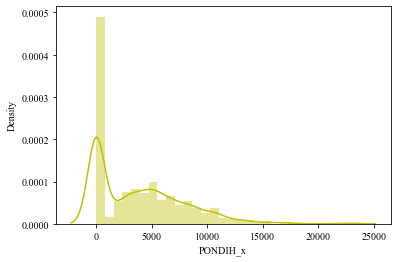

In [628]:
sns.distplot(eph_completa['PONDIH_x'],color="y")

plt.savefig('Histo15.eps', format='eps')


C:\Users\Abi\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered o

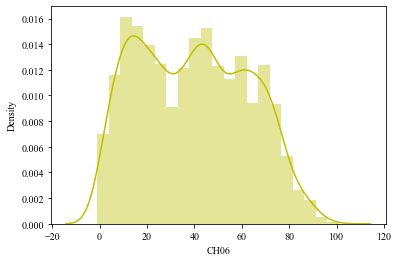

In [629]:
sns.distplot(eph_completa['CH06'],color="y")

plt.savefig('Histo16.eps', format='eps')


In [630]:
# Ahora eliminaremos las observaciones que no estén entre los quantiles 0.99 y 0. Utilizamo el quantil cero debido a que no queremos eliminar 
# a aquellos que tienen menores ingresos, debido a que las variables no categóricas son, en su mayoría, de ingreso. 




In [676]:
# Definimos la lista de las variables no categóricas 

variables_no_categoricas=['CH06','PP03D', 'PP3E_TOT', 'PP3F_TOT', 
'PP04B2', 'PP06C', 'PP06D', 'PP08D1', 
'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 
'PP08J2', 'PP08J3', 'P21', 'DECOCUR',
'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'PONDIIO',
'TOT_P12', 'P47T', 'DECINDR', 'RDECINDR',
'GDECINDR', 'ADECINDR', 'PONDII', 'V2_M',
'V3_M', 'V4_M', 'V5_M', 'V8_M', 
'V9_M', 'V10_M', 'V11_M', 'V12_M', 
'V18_M', 'V19_AM', 'V21_M', 'T_VI', 
'ITF_x', 'DECIFR_x', 'IDECIFR_x', 'RDECIFR_x',
'GDECIFR_x', 'PDECIFR_x', 'ADECIFR_x','IPCF_x', 
'DECCFR_x', 'IDECCFR_x', 'RDECCFR_x', 'GDECCFR_x', 
'PDECCFR_x', 'ADECCFR_x', 'PONDIH_x']

In [677]:
eph_final_completa=eph_completa

In [678]:
for var in variables_no_categoricas:
    # Lo primero que hacemos es enontrar el límite superior e inferior:
    limite_superior = eph_completa[var].quantile(0.99)
    limite_inferior = eph_completa[var].quantile(0)
    # Aplicamos el "recorte" de los datos: 
    eph_final_completa = eph_final_completa[(eph_final_completa[var] <= limite_superior) & (eph_final_completa[var] >= limite_inferior)]
    
    

In [679]:
# Observamos que se eliminaron 620 observaciones que, según el criterio utilizado, son outliers. De esta forma, nos quedan un total de 
# 3317 observaciones. 

len(eph_completa)-len(eph_final_completa)

617

In [680]:
eph_final_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,1,TQRMNOPPRHKMLNCDEIIAD00655703,1,1,1,32,1394,29.0,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,70000.000000,0.0,0.000000,0.000000,35000.000000,0.000000,0.000000,70000.0,9.0,9.0,9.0,8.0,1822.0,0.0,105000.0,10.0,10.0,10.0,9.0,1883.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255000.0,10.0,0.0,10.0,10.0,0.0,10.0,127500.0,10.0,0.0,10.0,10.0,0.0,10.0,2494.0,1,1,1,1,1,2,0,7,1,0.0,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,12.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,2,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,1,2,98,0,0,0
4,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,3,1,1,32,3090,22.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,3,2,5,1,1,1,1,7,2,2.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
5,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,4,1,1,32,3090,19.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,3,1,5,1,1,1,1,7,2,0.0,1,1,5,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,1,2,1,1,1,1,1,1,1,2,2,2,7,4,2,0,1,1,1,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,1,2,2,2,2,5,0,5,1,2,98,0,0,0
6,1,1,TQRMNOPPWHKMNUCDEIIAD00655837,5,1,1,32,3090,13.0,0.172712,38.051813,3.275187,0.063903,4538.721934,1688.773748,24980.243523,0.0,387.753598,29.872193,3219.638457,173.287277,8.347726,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,3090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,12.0,0.0,12.0,12.0,0.0,12.0,0.0,3,1,5,1,1,1,2,4,2,1.0,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [681]:

eph_categoricas= eph_final_completa.loc[:,['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4']]


In [682]:
eph_sin_categoricas=eph_final_completa.drop(columns = ['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [683]:
df_dummies = pd.get_dummies(eph_categoricas, 
                            columns=['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [684]:
# solo con el objetivo de realizar estadística desciptiva dejamos una versión de la base de datos en la que incluimos las variables 
# categóricas junto con las dummies 
eph_final_completa=pd.concat([eph_sin_categoricas,eph_categoricas,df_dummies], axis=1)

#### 6)

Las cinco variables que consideramos que podrían ser útiles para predecir pobreza son
las siguientes:


• IX_TOT: indica la cantidad de integrantes del hogar.


• NIVEL_ED: indica el nivel educativo del individuo encuestado.


• IV7: indica con un valor de 1 si el agua es de red pública, con un valor de 2 si es
de perforación con bomba a motir y con un valor de 3 si es de perforación con
bomba manual.


• V5: indica con un valor de 1 si en los tres últimos meses las personas del hogar
han vivido de un subsidio o ayuda social (en dinero) del gobierno, iglesias, entre
otros. Indica lo contratio con un valor igual a 2.


• II8: indica con un valor igual a 1 si el combustible utilizado es gas de red, con un
valor igual a 2 si este es gas de tubo o garrafa y con un valor de 3 si el combustible
utilicado es kerosene, leña o carbón. 



Es importante destacar que si alguna de las variables anteriores toma un valor igual a
9 esto significa que el encuestado no respondió a la pregunta 1
. También se indica con
un valor igual a 0 si el dato es missing. 


Realizamos gráficos de barras para cada una de estas variables (presentados a continuación). Además, en la Tabla (2) presentamos las estadísticas descriptivas. 



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


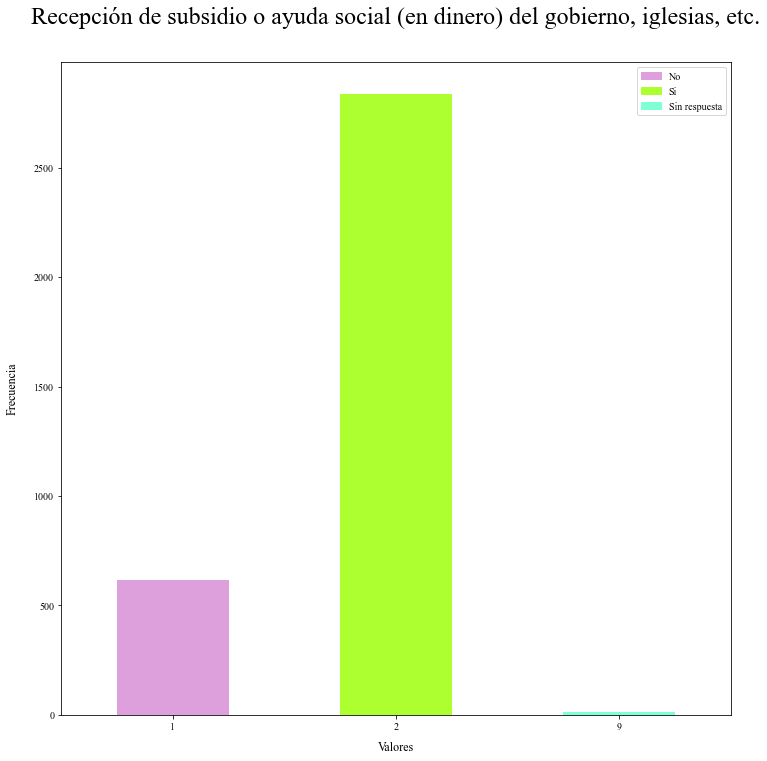

In [685]:
# Estadística descriptiva 

# En primer lugar dado que hemos elegido 5 variables categóricas, haremos gráficos con la frecuencia de cada respuesta para cada una de las variables elegidas: 

# Recordemos que las variables elegidas son: IV3, II9, IV12_3, V19_B, V5



#eph_final_completa['V5'].value_counts().plot(kind='bar', color=((0.7,0.9,0.6), (0.7,0.8,0.7),(0.7,0.8,0.2)),figsize=(7, 6), rot=0)
#plt.xlabel('Porcentaje de datos missing',labelpad=10,fontsize='12')
#plt.ylabel('Cantidad de variables',labelpad=15, fontsize='12')
#plt.title('Porcentaje de datos missing', y=1.05, fontsize='20')
#colors ={'Si':(0.7,0.9,0.6),'No':(0.7,0.8,0.7), 'Desconocido':(0.7,0.8,0.2)}
#labels = list(colors.keys())
#handles = [plt.Rectangle((1,1),0.5,0.5, color=colors[label]) for label in labels]
#plt.legend(handles, labels)
#

# Guardamos el gráfico: 

eph_final_completa.groupby('V5').count()['H15'].plot(kind='bar', color=('plum', 'greenyellow','aquamarine','tomato','violet'),figsize=(12, 12), rot=0)
plt.xlabel('Valores',labelpad=10,fontsize='12')
plt.ylabel('Frecuencia',labelpad=15, fontsize='12')
plt.title('Recepción de subsidio o ayuda social (en dinero) del gobierno, iglesias, etc.', y=1.05, fontsize='24')
colors ={'No':'plum','Si':'greenyellow','Sin respuesta':'aquamarine'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
plt.legend(handles, labels)
    

plt.savefig('V5.eps', format='eps')




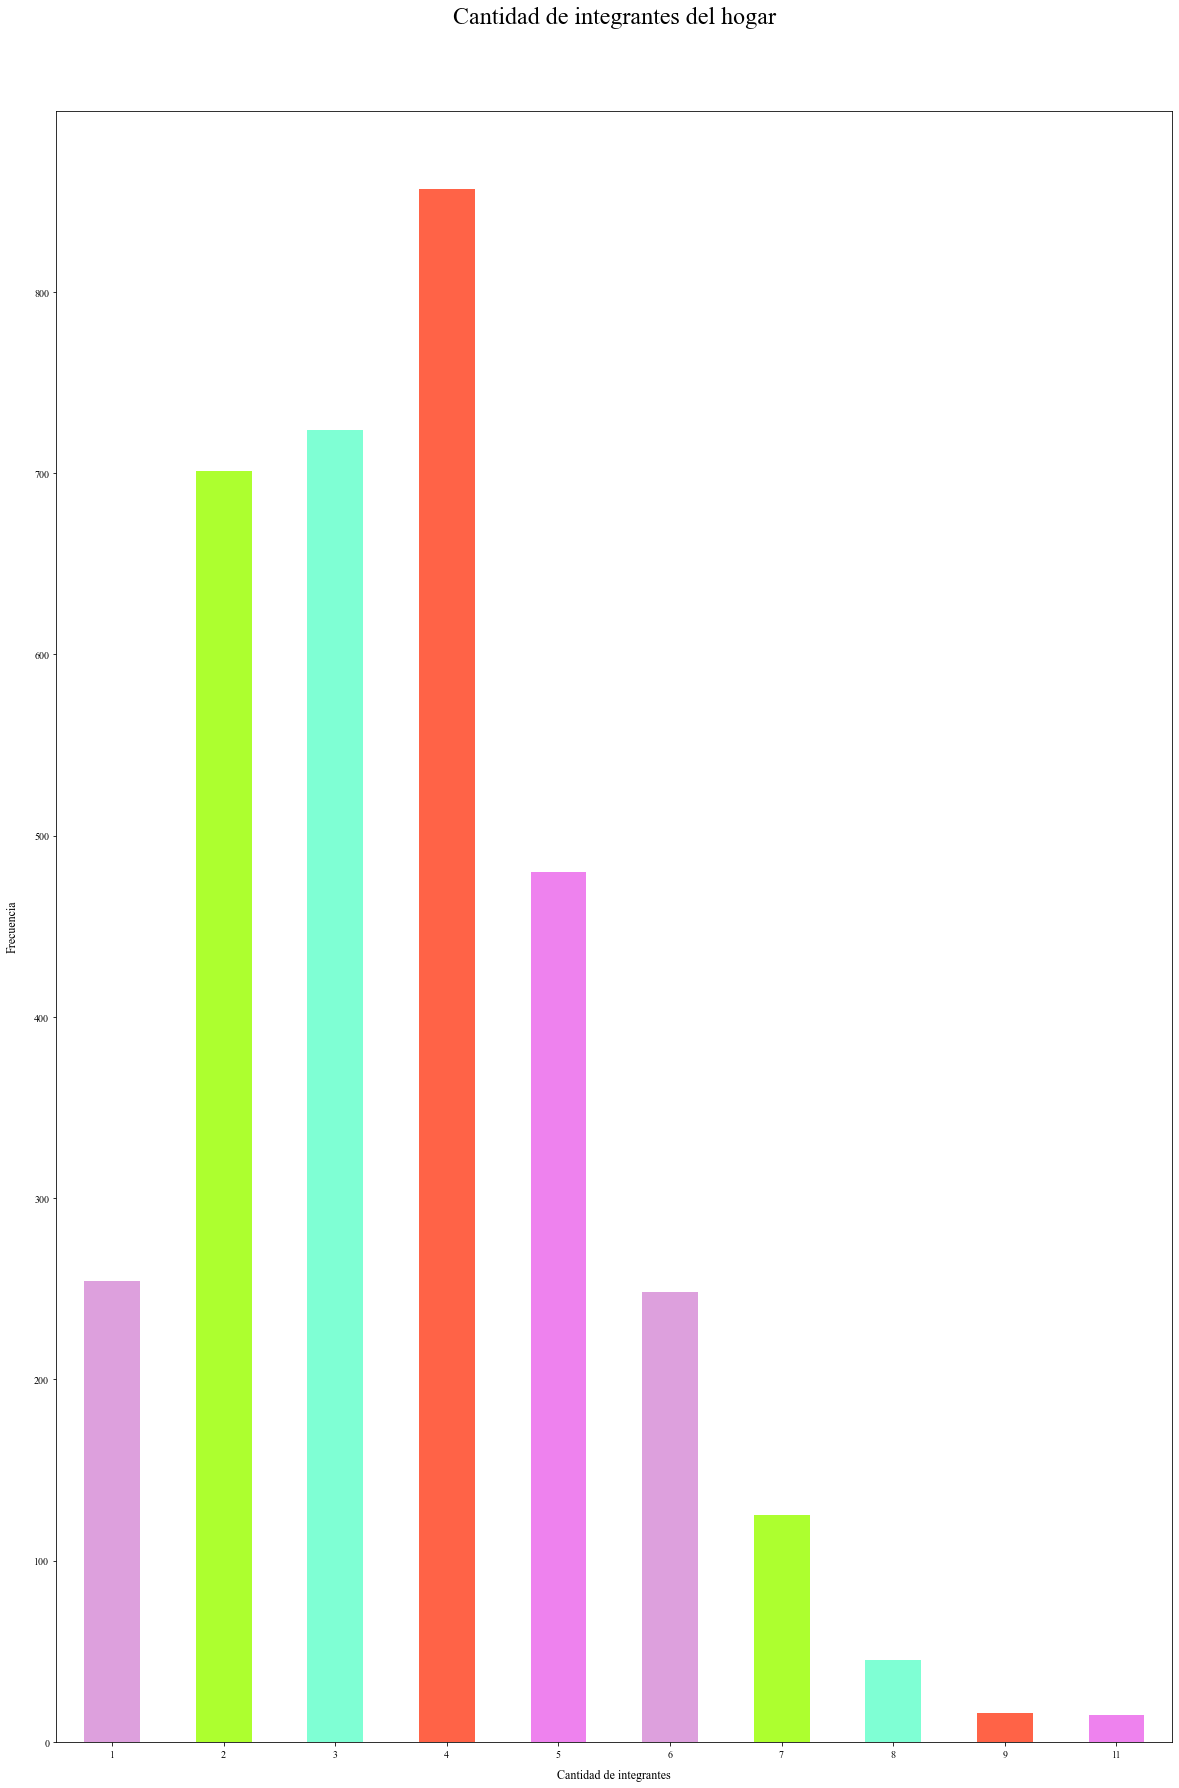

In [686]:

eph_final_completa.groupby('IX_TOT').count()['H15'].plot(kind='bar', color=('plum', 'greenyellow',
                                                                           'aquamarine','tomato','violet'),
                                                                            figsize=(20, 30), rot=0)
plt.xlabel('Cantidad de integrantes',labelpad=10,fontsize='12')
plt.ylabel('Frecuencia',labelpad=15, fontsize='12')
plt.title('Cantidad de integrantes del hogar', y=1.05, fontsize='24')

handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]

    

plt.savefig('IX_TOT.eps', format='eps')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


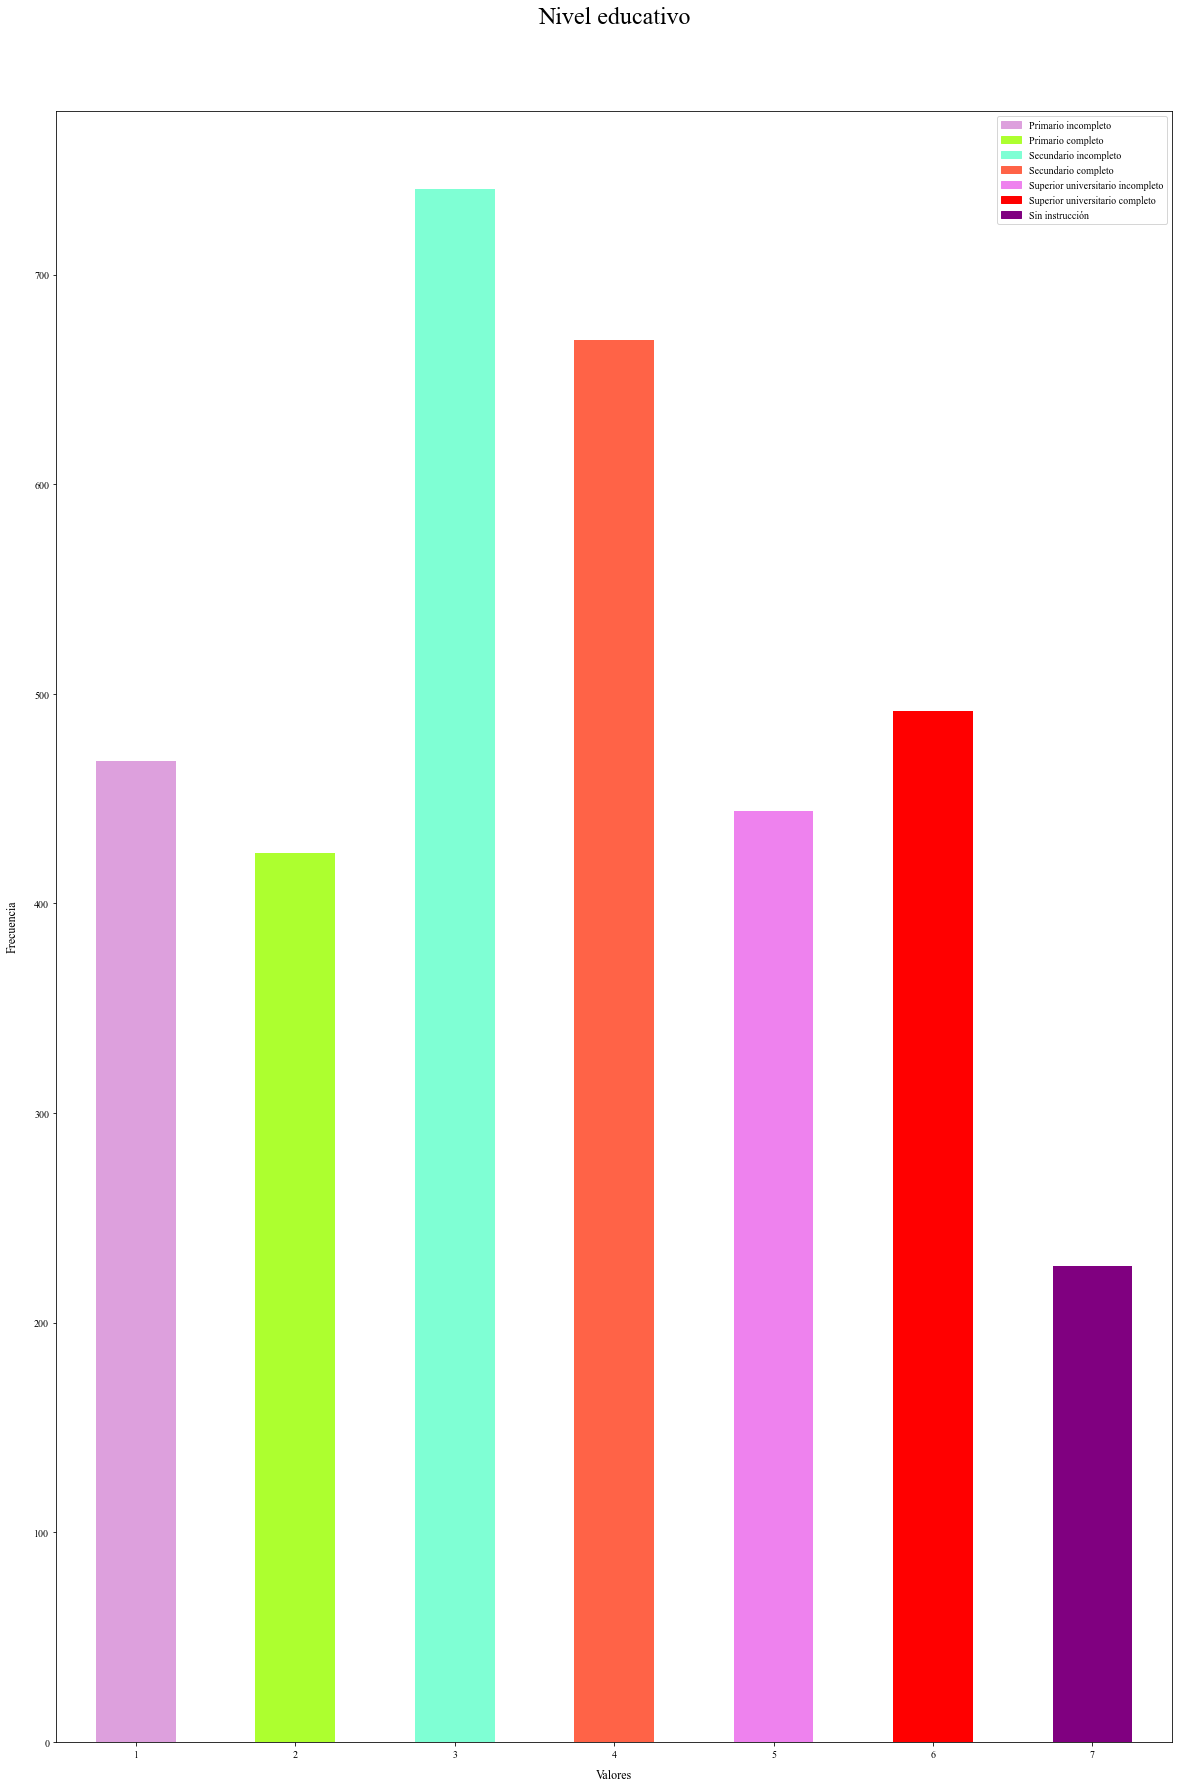

In [687]:


eph_final_completa.groupby('NIVEL_ED').count()['H15'].plot(kind='bar', color=('plum', 'greenyellow','aquamarine','tomato','violet','red', 'purple', 'black'),figsize=(20, 30), rot=0)
plt.xlabel('Valores',labelpad=10,fontsize='12')
plt.ylabel('Frecuencia',labelpad=15, fontsize='12')
plt.title('Nivel educativo', y=1.05, fontsize='24')
colors ={'Primario incompleto':'plum','Primario completo':'greenyellow', 'Secundario incompleto':'aquamarine','Secundario completo':'tomato','Superior universitario incompleto':'violet','Superior universitario completo':'red', 'Sin instrucción':'purple'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
plt.legend(handles, labels)
    

plt.savefig('NIVEL_ED.eps', format='eps')







The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


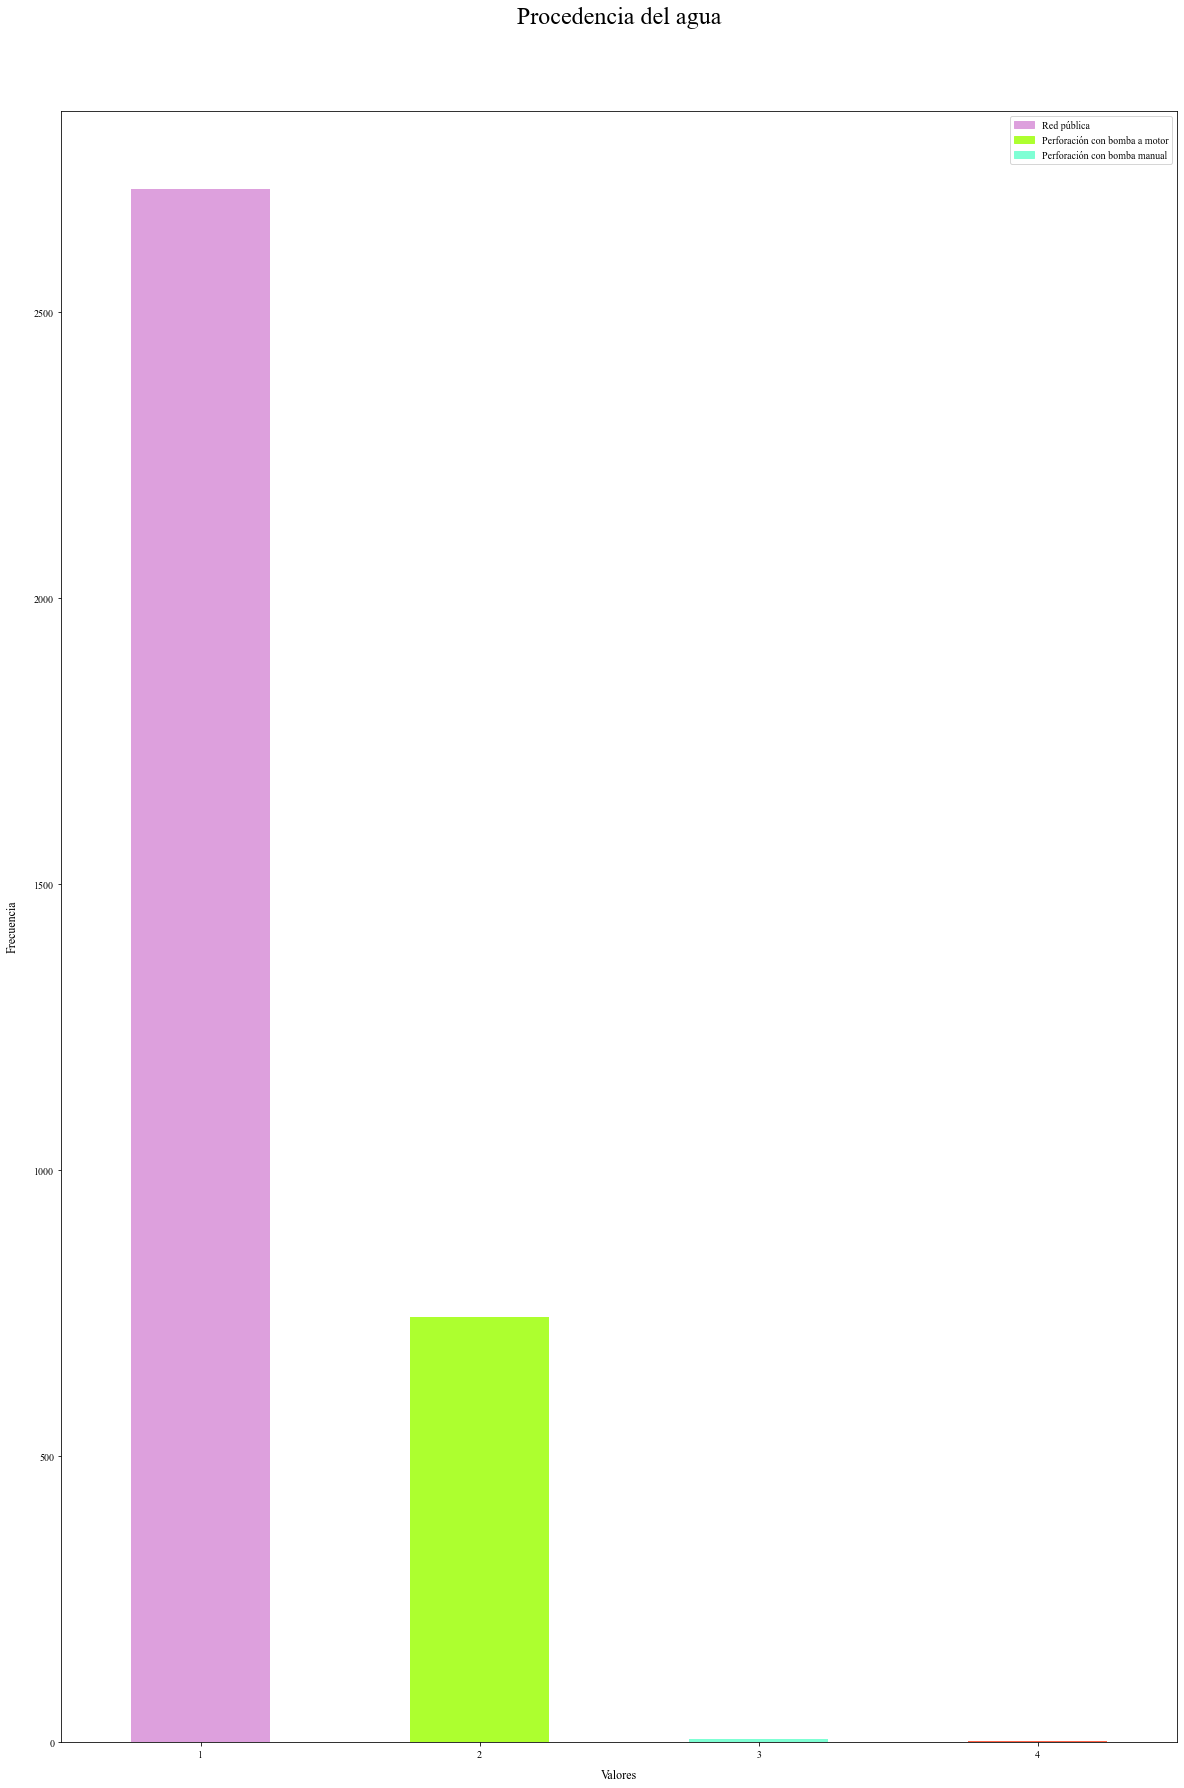

In [688]:
eph_final_completa.groupby('IV7').count()['H15'].plot(kind='bar', color=('plum', 'greenyellow','aquamarine','tomato','violet'),figsize=(20, 30), rot=0)
plt.xlabel('Valores',labelpad=10,fontsize='12')
plt.ylabel('Frecuencia',labelpad=15, fontsize='12')
plt.title('Procedencia del agua', y=1.05, fontsize='24')
colors ={'Red pública':'plum','Perforación con bomba a motor':'greenyellow','Perforación con bomba manual':'aquamarine'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
plt.legend(handles, labels)
    

plt.savefig('IV7.eps', format='eps')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


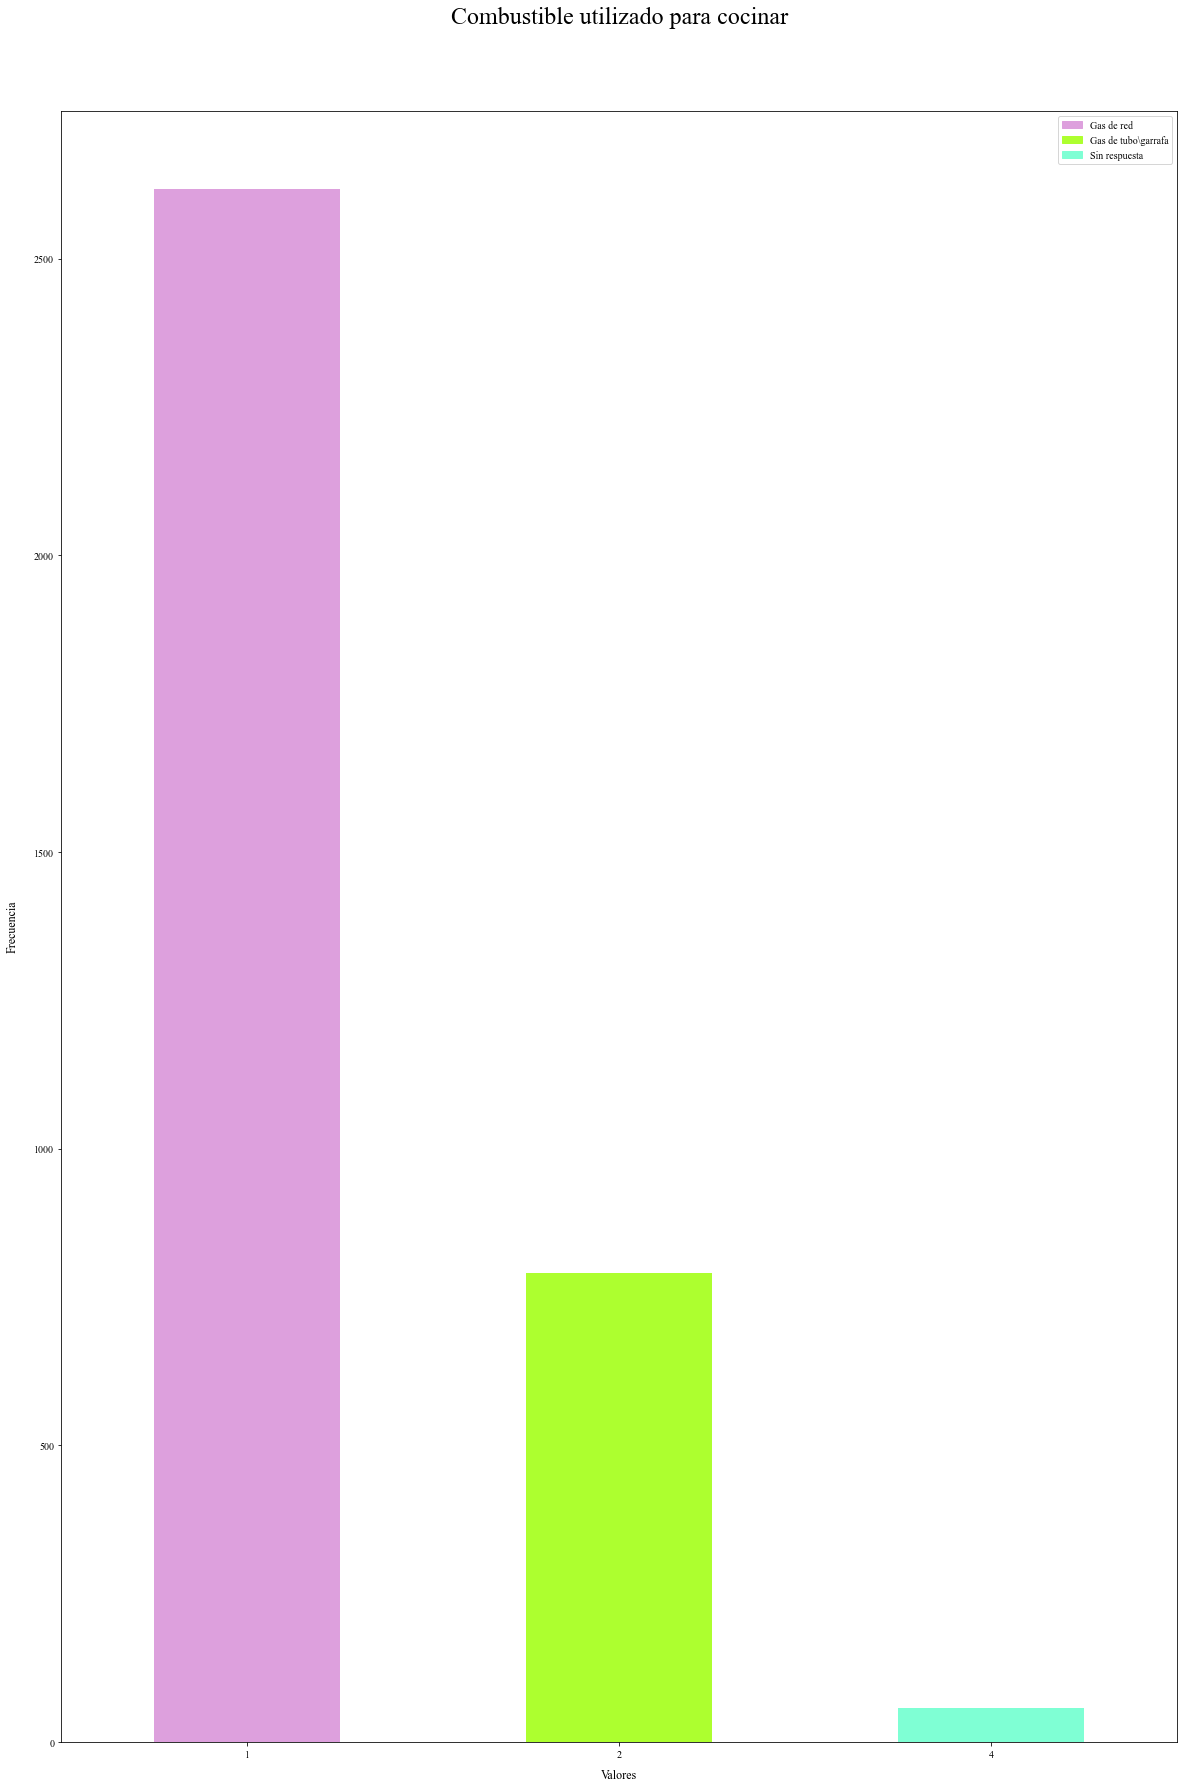

In [689]:
#II8

eph_final_completa.groupby('II8').count()['H15'].plot(kind='bar', color=('plum', 'greenyellow','aquamarine','tomato','violet'),figsize=(20, 30), rot=0)
plt.xlabel('Valores',labelpad=10,fontsize='12')
plt.ylabel('Frecuencia',labelpad=15, fontsize='12')
plt.title('Combustible utilizado para cocinar', y=1.05, fontsize='24')
colors ={'Gas de red':'plum','Gas de tubo\garrafa':'greenyellow','Sin respuesta':'aquamarine'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
plt.legend(handles, labels)
    
plt.savefig('II8.eps', format='eps')




In [690]:
freq = eph_final_completa['IV7'].value_counts() 
print(freq)

1    2716
2     742
3       5
4       2
Name: IV7, dtype: int64


In [691]:
freq = eph_final_completa['IX_TOT'].value_counts() 
print(freq)

4     857
3     724
2     701
5     480
1     254
6     248
7     125
8      45
9      16
11     15
Name: IX_TOT, dtype: int64


In [692]:
freq = eph_final_completa['NIVEL_ED'].value_counts() 
print(freq)

3    741
4    669
6    492
1    468
5    444
2    424
7    227
Name: NIVEL_ED, dtype: int64


In [693]:

freq = eph_final_completa['II8'].value_counts() 
print(freq)


1    2618
2     790
4      57
Name: II8, dtype: int64


In [941]:

freq = eph_final_completa['V5'].value_counts() 
print(freq)


2    2839
1     615
9      11
Name: V5, dtype: int64


Tabla 2 

In [942]:
eph_table=eph_final_completa.loc[:,['IV7','IX_TOT','NIVEL_ED','II8','V5']].describe().loc[["count","max","min","mean", "std"]].T

In [943]:
eph_table

,count,max,min,mean,std
IV7,3465.0,4.0,1.0,1.218759,0.421075
IX_TOT,3465.0,11.0,1.0,3.661760,1.687953
NIVEL_ED,3465.0,7.0,1.0,3.744877,1.772128
II8,3465.0,4.0,1.0,1.277345,0.547003
V5,3465.0,9.0,1.0,1.844733,0.555901


In [696]:
eph_table.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &   count &   max &  min &      mean &       std \\\\\n\\midrule\nIV7      &  3465.0 &   4.0 &  1.0 &  1.218759 &  0.421075 \\\\\nIX\\_TOT   &  3465.0 &  11.0 &  1.0 &  3.661760 &  1.687953 \\\\\nNIVEL\\_ED &  3465.0 &   7.0 &  1.0 &  3.744877 &  1.772128 \\\\\nII8      &  3465.0 &   4.0 &  1.0 &  1.277345 &  0.547003 \\\\\nV5       &  3465.0 &   9.0 &  1.0 &  1.844733 &  0.555901 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### 7) 

In [697]:
equivalencia=pd.read_excel('tabla_adulto_equiv.xlsx')

In [698]:
# Guardamos los valores de las celdas en las listas 
equivalencia_filas=equivalencia.to_numpy().transpose().tolist()

In [699]:
# La idea es crear dos bases de datos distintas para luego hacer el merge con la EPH. 
# Estas dos bases de van a diferenciar en una variable "sexo" que tomará, para todas las observaciones, 
# un valor de 1 o 2. 

# En primer lugar, procederemos a armar la primera fila de los dos data frame
# Esta fila tendrá los valores referidos a la edad, es por esto que es una fila en común 
# entre ambas bases de datos. 

# Nos quedamos con el primer elemento de "equivalencia_filas" (edad):

fila0=equivalencia_filas[0]

# Nos quedamos solo con los valores que no son missings:

edad = [x for x in fila0 if pd.isnull(x) == False]

# Armamos la base de datos para las mujeres

# Nos quedamos solo con los elementos de la fila que nos van a servir (hay algunos 
# datos de edad que no son missing pero no son referidos a la edad sino que son notas)

edad=edad[1:24]

print(edad)

# Nos quedamos con la fila referida a la equivalencia:

fila1=equivalencia_filas[1]

mujeres_eq = [x for x in fila1 if pd.isnull(x) == False]

# Nos quedamos solo con los elementos de la fila que nos van a servir 

mujeres_eq=mujeres_eq[1:24]

print(mujeres_eq)

# Creamos una fila que tome valor igual a 2, esto será para luego poder hacer el merge 
# con la base de datos de la EPH

sexo=[2] * 24

print(sexo)

# Juntamos las filas y las transformamos en un data frame. 

mujeres = list(zip(edad, mujeres_eq, sexo))

# Cambiamos los nombres de las variables para que podamos hacer el merge con la EPH sin ninguna complicación

df_mujeres = pd.DataFrame(mujeres,columns=['edad','equivalencia','CH04'])

# Observamos el resultado

df_mujeres.head(5)

['Menor de 1 año', '1año', '2 años', '3 años', '4 años', '5 años', '6 años', '7 años', '8 años', '9 años', '10 años', '11 años', '12 años', '13 años', '14 años', '15 años', '16 años', '17 años', '18 a 29 años', '30 a 45 años', '46 a 60 años', '61 a 75 años', 'más de 75 años']
[0.35, 0.37, 0.46, 0.51, 0.55, 0.6, 0.64, 0.66, 0.68, 0.69, 0.7, 0.72, 0.74, 0.76, 0.76, 0.77, 0.77, 0.77, 0.76, 0.77, 0.76, 0.67, 0.63]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


,edad,equivalencia,CH04
0,Menor de 1 año,0.35,2
1,1año,0.37,2
2,2 años,0.46,2
3,3 años,0.51,2
4,4 años,0.55,2


In [700]:
# Armamos la base de datos para los hombres 

# Nos quedamos solo con los elementos de la fila que nos van a servir 

fila1_hombres=equivalencia_filas[2]

# Eliminamos los missing values

# esto sería: hombres_eq = [x for x in fila1_hombres (cambia esto) if pd.isnull(x) == False]

hombres_eq = [x for x in fila1_hombres if pd.isnull(x) == False]

# Nos quedamos solo con los elementos de la fila que nos van a servir 

hombres_eq = hombres_eq[1:24]

print(hombres_eq)

# Creamos una fila que tome valor igual a 1, esto será para luego poder hacer el merge 
# con la base de datos de la EPH

sexo=[1] * 24

print(sexo)

# Juntamos las filas y las transformamos en un data frame. 

hombres = list(zip(edad, hombres_eq, sexo))

# Cambiamos los nombres de las variables para que podamos hacer el merge con la EPH sin ninguna complicación

df_hombres = pd.DataFrame(hombres,columns=['edad','equivalencia','CH04'])

# Observamos el resultado

df_hombres.head(5)


[0.35, 0.37, 0.46, 0.51, 0.55, 0.6, 0.64, 0.66, 0.68, 0.69, 0.79, 0.82, 0.85, 0.9, 0.96, 1, 1.03, 1.04, 1.02, 1, 1, 0.83, 0.74]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,edad,equivalencia,CH04
0,Menor de 1 año,0.35,1
1,1año,0.37,1
2,2 años,0.46,1
3,3 años,0.51,1
4,4 años,0.55,1


In [701]:
# Creamos una función que nos 
def combinacion_edad(x):
   
    #Esta función nos devuelve la categoría en la que entra cada individuo
    #según la edad que tenga, con categoría nos ayudará a hacer el match 
    #de la base de datos de la EPH con la tabla de equivalencias
    #Input: 
    #  edad (int): la edad a la que se desea transformar en esa misma edad solo que "con palabras"
    # Output:
    #  str: edad en palabras

    if x < 1:
        return 'Menor de 1 año'
    elif x == 1:
        return '1 año'
    elif x ==2: 
        return '2 años'
    elif x ==3: 
        return '3 años'
    elif x ==4: 
        return '4 años'
    elif x ==5: 
        return '5 años'
    elif x ==6: 
        return '6 años'
    elif x ==7: 
        return '7 años'
    elif x ==8: 
        return '8 años'
    elif x ==9: 
        return '9 años'
    elif x ==10: 
        return '10 años'
    elif x ==11: 
        return '11 años'
    elif x ==12: 
        return '12 años'
    elif x ==13: 
        return '13 años'
    elif x ==14: 
        return '14 años'
    elif x ==15: 
        return '15 años'
    elif x ==16: 
        return '16 años'
    elif x ==17: 
        return '17 años'      
    elif x >= 18 and x <= 29:
        return '18 a 29 años'
    elif x >= 30 and x <= 45:
        return '30 a 45 años'  
    elif x >= 46 and x <= 60:
        return '46 a 60 años'    
    elif x >= 61 and x <= 75:
        return '61 a 75 años'
    else:
        return 'mas de 75 años'


In [702]:
# Agregamos una nueva columna con la edad, en donde aplicamos la función 
eph_final_completa['edad']=[combinacion_edad(x) for x in eph_final_completa['CH06']]

eph_final_completa.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH07_9,CH08_1,CH08_2,CH08_3,CH08_4,CH08_12,CH09_1,CH09_2,CH09_3,CH09_9,CH10_0,CH10_1,CH10_2,CH10_3,CH10_9,CH11_0,CH11_1,CH11_2,CH11_9,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH13_9,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH15_9,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,CH16_9,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03G_0.0,PP03G_1.0,PP03G_2.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_0.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_0.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_0.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,PP04A_0.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_0.0,PP04B1_1.0,PP04B1_2.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_3.0,PP05B2_ANO_5.0,PP05B2_ANO_8.0,PP05B2_DIA_0.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06E_0.0,PP06E_1.0,PP06E_3.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP07A_0.0,PP07A_1.0,PP

In [703]:
# Hacemos el merge de la EPH con la base de datos de equivalencia para hombres

result = pd.merge(eph_final_completa, df_hombres, how="left", on=["edad","CH04"])


In [704]:
# Hacemos el merge de la EPH con la base de datos de equivalencia para mujeres

result_eph = pd.merge(result, df_mujeres, how="left", on=["CH04", "edad"])

In [705]:
# Debido a que queremos tener los datos de equivalencia en una sola columna juntamos los datos de "equivalencia_x" y "equivalencia_y"
# en una sola columna. Notar que si hay valores missing en ambas columnas esto se mantiene en la nueva columna llamada "Equivalencia"

result_eph["Equivalencia"]=result_eph["equivalencia_x"].combine_first(result_eph["equivalencia_y"])

In [706]:
# Observamos los resultados 

result_eph.head()

,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH07_9,CH08_1,CH08_2,CH08_3,CH08_4,CH08_12,CH09_1,CH09_2,CH09_3,CH09_9,CH10_0,CH10_1,CH10_2,CH10_3,CH10_9,CH11_0,CH11_1,CH11_2,CH11_9,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH13_9,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH15_9,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,CH16_9,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03G_0.0,PP03G_1.0,PP03G_2.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_0.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_0.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_0.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,PP04A_0.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_0.0,PP04B1_1.0,PP04B1_2.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_3.0,PP05B2_ANO_5.0,PP05B2_ANO_8.0,PP05B2_DIA_0.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06E_0.0,PP06E_1.0,PP06E_3.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP07A_0.0,PP07A_1.0,PP

In [707]:

# El archivo de consideraciones metodológicas del INDEC sobre la EPH nos dice que para agrupar por edades necesitamos usar 
# CODUSO y NRO_HOGAR. 

# Armamos una nueva base de datos que contenga las variables CODUSU, NRO_HOGAR y Equivalencia y las agrupamos por CODUSO y NRO_HOGAR
eph_equiv = result_eph[['CODUSU', 'NRO_HOGAR', 'Equivalencia']].groupby(['CODUSU', 'NRO_HOGAR']).sum().reset_index()
# Le damos el nombre a las columnas del data frame anterior
eph_equiv.rename(columns = {'Equivalencia': 'ad_equiv_hogar'}, inplace = True) 

# Unimos las base anterior con la base completa (result_eph), de esta forma, cada individuo tiene el valor correspondiente 
# de eph equiv por familia
eph_final = pd.merge(result_eph, eph_equiv, how='left', on=['CODUSU', 'NRO_HOGAR'])

#### 8) 

In [708]:
(eph_final['ITF_x']==0).sum() # 1390


1390

In [709]:
(eph_final['ITF_x']>0).sum() # 2075


2075

In [892]:
# Guardamos como bases distintas según si respondieron o no ITF

respondieron = eph_final.loc[eph_final['ITF_x']>0]

no_respondieron = eph_final.loc[eph_final['ITF_x']==0]

In [893]:
# Creamos la variable ingreso_necesario en la base de datos "respondieron", esta variable resulta de multiplicar 
# 18914 por cada valor de "ad_equiv_hogar"

respondieron['ingreso_necesario']=18914*respondieron['ad_equiv_hogar']

# Observamos los resultados

respondieron.head(4)


<ipython-input-893-1e5a917ebcea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario']=18914*respondieron['ad_equiv_hogar']


,TRIMESTRE_x,NRO_HOGAR,CODUSU,COMPONENTE,H15,REGION_x,AGLOMERADO_x,PONDERA_x,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF_x,DECIFR_x,IDECIFR_x,RDECIFR_x,GDECIFR_x,PDECIFR_x,ADECIFR_x,IPCF_x,DECCFR_x,IDECCFR_x,RDECCFR_x,GDECCFR_x,PDECCFR_x,ADECCFR_x,PONDIH_x,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH07_9,CH08_1,CH08_2,CH08_3,CH08_4,CH08_12,CH09_1,CH09_2,CH09_3,CH09_9,CH10_0,CH10_1,CH10_2,CH10_3,CH10_9,CH11_0,CH11_1,CH11_2,CH11_9,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH13_9,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH15_9,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,CH16_9,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03G_0.0,PP03G_1.0,PP03G_2.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_0.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_0.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_0.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,PP04A_0.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_0.0,PP04B1_1.0,PP04B1_2.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_3.0,PP05B2_ANO_5.0,PP05B2_ANO_8.0,PP05B2_DIA_0.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06E_0.0,PP06E_1.0,PP06E_3.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP07A_0.0,PP07A_1.0,PP

In [894]:
# Calculamos la media de la variable ingreso necesario 

respondieron['ingreso_necesario'].mean() # 47114.54612048203


47114.54612048203

In [895]:
# Calculamos la media de la variable ITF

respondieron['ITF_x'].mean() # 75540.31084337349

75540.31084337349

#### 9)

In [896]:
# A continuacion eliminamos las variables categóricas debido a que fueorn transformadas en dummies: 

respondieron=respondieron.drop(columns = ['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [897]:
no_respondieron=no_respondieron.drop(columns = ['CH03',
 'CH04',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH16',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B1',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 'PP07G_59',
 'PP07H',
 'PP07I',
 'PP07J',
 'PP07K',
 'PP09A',
 'PP09B',
 'PP09C',
 'IV1',
 'IV2',
 'IV3',
 'IV4',
 'IV5',
 'IV6',
 'IV7',
 'IV8',
 'IV9',
 'IV10',
 'IV11',
 'IV12_1',
 'IV12_2',
 'IV12_3',
 'II1',
 'II2',
 'II3',
 'II3_1',
 'II4_1',
 'II4_2',
 'II4_3',
 'II5',
 'II5_1',
 'II6',
 'II6_1',
 'II7',
 'II8',
 'II9',
 'V1',
 'V2',
 'V21',
 'V22',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19_A',
 'V19_B',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'VII1_1',
 'VII1_2',
 'VII2_1',
 'VII2_2',
 'VII2_3',
 'VII2_4'])

In [898]:
# Creamos la variable pobre: 

# En principio solo toma como valor cero

respondieron['pobres']=0

# Reemplazamos con 1 en la variable 'pobre' si el ingreso necesario es menor al ITF que se respondió en la encuesta

respondieron.loc[respondieron.ingreso_necesario > respondieron.ITF_x, 'pobres']=1

In [899]:
# Calculamos la cantidad de pobres: 

respondieron['pobres'].value_counts()


0    1397
1     678
Name: pobres, dtype: int64

In [900]:
# Generamos una tabla de estadística descriptiva de la variable pobres 

respondieron['pobres'].describe()

count    2075.000000
mean        0.326747
std         0.469137
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: pobres, dtype: float64

In [901]:
len(respondieron.index)

2075

In [902]:
type(respondieron)

pandas.core.frame.DataFrame

#### 10) 

La tasa de hogares bajo la línea de pobreza reportada por el INDEC es de 31,2%, esta
es muy similar a la calculada en este trabajo: 35.66%. Entre ambas tasas hay una diferencia de 4.46 puntos porcentuales.

In [903]:
# Definimos una base que contenga el ponderador y la columna que indica si el individuo es pobre o no agrupando por familia, de esta forma, queda una 
# sola observacion por familia, es decir, un solo individuo por familia

base_por_individuo=respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"PONDIH_x" : "sum", "pobres" : "mean"})

In [904]:
base_por_individuo.head()

,,PONDIH_x,pobres
CODUSU,NRO_HOGAR,,
TQRMNOPPQHJMQLCDEIJAH00702455,1,8056.0,0
TQRMNOPPQHJNMQCDEIJAH00698190,1,21840.0,1
TQRMNOPPQHJONQCDEIJAH00693114,1,4572.0,0
TQRMNOPPQHKMOSCDEIJAH00656008,1,15114.0,0
TQRMNOPPQHLMPPCDEIJAH00701610,1,25165.0,0


In [905]:
base_por_individuo.groupby("pobres").PONDIH_x.sum()

pobres
0    7963673.0
1    4413910.0
Name: PONDIH_x, dtype: float64

In [947]:
# De esta forma, la la tasa de hogares bajo la línea de pobreza para el GBA es del 35.66%

tasa_pobreza=4413910.0/(4413910.0+7963673.0)

tasa_pobreza

0.3566051627365375

## Parte 2

#### 1) 

In [ ]:
def evalua_metodo_1(modelo, X_train, y_train, X_test, y_test,h):
    '''
    Input: 
    Output: 
    
    '''
    if modelo=='regresion_lineal':
        lin_reg = LinearRegression()
        lin_reg=lin_reg.fit(X_train, y_train)
        y_pred = lin_reg.predict(X_test)
        # Usamos el clasificador de Bayes 
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        # Matriz de confusión y accuracy score
        matriz_confusion = confusion_matrix(y_test, y_pred)
        #Calculamos el área bajo la curva ROC
        auc = roc_auc_score(y_test, y_pred)
        prec=accuracy_score(y_test, y_pred)
        # Calculamos el ECM
        ecm = sklearn.metrics.mean_squared_error(y_test, y_pred)
        #A = np.array([['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'],[modelo,'none','none','none',ecm]])
        A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])
        B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
        return(B)
    if modelo=='regresion_logistica':
        log_reg = LogisticRegression(**h, solver='saga', l1_ratio = 0.9)
        log_reg=log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
        # Matriz de confusión y accuracy score
        matriz_confusion = confusion_matrix(y_test, y_pred)
        #Calculamos el área bajo la curva ROC
        auc = roc_auc_score(y_test, y_pred)
        prec=accuracy_score(y_test, y_pred)
        # Calculamos el ECM
        ecm = sklearn.metrics.mean_squared_error(y_test, y_pred)
        #A = np.array([['Matriz de confusión','La presición del modelo es','AUC','ECM'],[matriz_confusion,prec,auc,ecm]])
        #B=float(A[1][3])
        #C=float(A[1][1])
        #D=float(A[1][2])
        #return([B, modelo])
        A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])
        B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
        return(B)
        
        #prueba
        #B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
        #return(B)
    if modelo=='analisis_discriminante':
        lda = LinearDiscriminantAnalysis()
        lda = lda.fit(X_train, y_train)
        y_pred=lda.predict(X_test)
        # Matriz de confusión y accuracy score
        matriz_confusion = confusion_matrix(y_test, y_pred)
        #Calculamos el área bajo la curva ROC
        auc = roc_auc_score(y_test, y_pred)
        prec=accuracy_score(y_test, y_pred)
        # Calculamos el ECM
        ecm = sklearn.metrics.mean_squared_error(y_test, y_pred)
        A = np.array([[modelo, matriz_confusion,prec,auc,ecm]])
        B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM'])
        return(B)        
    if modelo=='k_vecinos_cercanos':
        # Además de calcular el modelo para k=3, vamos a verificar cuál es la cantidad de vecinos 
        # cercanos maximiza el "testing accuracy" (una medida de precisión en la predicción)
        k_range = range(1,20)
        scores = {}      # Para guardar la precisión en un diccionario
        scores_list = [] # Para guardar la precisión en una lista
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            scores[k] = accuracy_score(y_test, y_pred)
            scores_list.append(accuracy_score(y_test, y_pred))
        score_max=max(scores_list)
        k_elegido=scores_list.index(score_max)
        k_final=k_elegido+1    
        # Modelo de KNN con k=k_elegido
        knn = KNeighborsClassifier(n_neighbors=k_final, metric='euclidean')
        knn.fit(X_train, y_train) 
        y_pred = knn.predict(X_test)
        # Matriz de confusión y accuracy score
        matriz_confusion = confusion_matrix(y_test, y_pred)
        # Calculamos el área bajo la curva ROC
        auc = roc_auc_score(y_test, y_pred)
        prec=accuracy_score(y_test, y_pred)
        # Calculamos el ECM
        ecm = sklearn.metrics.mean_squared_error(y_test, y_pred)
        A = np.array([[modelo,matriz_confusion,prec,auc,ecm,k_final]])
        B=pd.DataFrame(A, columns=['Modelo','Matriz de confusión','La presición del modelo es','AUC','ECM','grado'])
        return(B) 
    

#### 2) 

In [ ]:
def cross_validation(modelo, k, X,y,h):
    '''
    Input: 
    Output:    
    ''' 
    #ecms_prueba = pd.DataFrame(columns=["Modelo", "particion2", "ecm2","configuracion"])
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    kf.get_n_splits(X)
    KFold(n_splits=k, random_state=None, shuffle=False)
    for train_index, test_index in kf.split(X):   
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        ecm1 = evalua_metodo_1(modelo, X_train, y_train, X_test, y_test,h)
        return(ecm1)
        #ecms_prueba = ecms_prueba.append(ecm, ignore_index=True)   
   # return(ecms_prueba)   


#### 3) 

In [ ]:
def evalua_config(modelo, lista_grados,k,X,y):
    matriz_completa = pd.DataFrame(columns=["Modelo", "Matriz de confusión", "La presición del modelo es","AUC","ECM","grado","configuracion"])
    for grade in lista_grados:
        h = [{"penalty":'l1', 'C': grade}, {"penalty": 'l2', 'C': grade}, {"penalty": 'elasticnet', 'C': grade}]
        matriz_completa_1 = pd.DataFrame(columns=["Modelo", "Matriz de confusión", "La presición del modelo es","AUC","ECM","grado"])
        for config in h:
            matriz_c = cross_validation(modelo, k,X,y,config)
            matriz_c['grado']=grade
            print(grade)
            matriz_c['configuracion']=config['penalty']
            print(config)
            matriz_completa = matriz_completa.append(matriz_c,ignore_index=True)
            matriz_completa['ECM'] = pd.to_numeric(matriz_completa['ECM'])
    #matriz_promedio = matriz_completa.groupby('grado').agg({"Modelo":'min',"La presición del modelo es":'min',"AUC":'min',"ECM":'min',"configuracion":'min'}).reset_index()
    ecm_minimo = matriz_completa.nsmallest(1, 'ECM')
    return(ecm_minimo)
    #matriz_completa_1 = matriz_completa_1.append(ecm_minimo, ignore_index=True) 
    # no corremos la función cross_validation dos veces debido a que podemos obtener las métricas y a la vez seleccionar el
    # parámetro que tiene ecm menor
    #return(ecm_minimo)
    ### ecm_minimo_final_1 = matriz_completa_1.nsmallest(1, 'ECM')
    ### return(ecm_minimo_final_1)

#### 4) 

In [ ]:
def evalua_multiples_metodos(lista_parametros, X, y, k):
    modelos = ['regresion_lineal','regresion_logistica','k_vecinos_cercanos','analisis_discriminante']
    #,'regresion_logistica','analisis_discriminante','k_vecinos_cercanos'
    matriz = pd.DataFrame(columns=["grado","Modelo", "La presición del modelo es", "AUC","ECM","configuracion"])
    for modelo in modelos:
        if modelo=='regresion_logistica':
            ecm_rl=evalua_config('regresion_logistica',lista_parametros,k,X,y)
            #return(ecm_rl)
        if modelo =='k_vecinos_cercanos':
            ecm_kvc=evalua_metodo_1('k_vecinos_cercanos', X_train, y_train, X_test, y_test,k)
            ecm_kvc['configuracion']='none' 
            ecm_kvc['grado']=19
            #return(ecm_kvc)
        if modelo == 'regresion_lineal': #ver si hay que agregar el none en la primera funcion 
            ecm_rlineal=evalua_metodo_1('regresion_lineal', X_train, y_train, X_test, y_test,k)
            ecm_rlineal['grado']='none'
            ecm_rlineal['configuracion']='none'
            #return(ecm_rlineal)
        if modelo == 'analisis_discriminante':
            ecm_ad=evalua_metodo_1('analisis_discriminante', X_train, y_train, X_test, y_test,k) 
            ecm_ad['grado']='none'
            ecm_ad['configuracion']='none'
            #return(ecm_ad)
    matriz=pd.concat([ecm_rl, ecm_rlineal, ecm_ad, ecm_kvc], axis=0)
    return(matriz)



## Parte 3 

#### 1) 

In [909]:
# Eliminamos algunas columnas de la base de datos  (esto va en la parte 3) !!!!!


b = ['ITF_x','Equivalencia','ad_equiv_hogar','AGLOMERADO_x', 'edad','equivalencia_x','equivalencia_y','DECIFR_x','IDECIFR_x','RDECIFR_x',
     'GDECIFR_x', 'PDECIFR_x', 'ADECIFR_x','IPCF_x','DECCFR_x', 'IDECCFR_x', 
     'RDECCFR_x', 'GDECCFR_x', 'PDECCFR_x', 'ADECCFR_x', 'P21', 'DECOCUR','RDECOCUR',
     'GDECOCUR','ADECOCUR','TOT_P12','P47T','DECINDR','RDECINDR','GDECINDR','ADECINDR',
     'V2_M','V3_M','V4_M','V5_M','V8_M','V9_M','V10_M','V11_M','V12_M','V18_M','V19_AM',
     'V21_M','T_VI','TRIMESTRE_x', 'NRO_HOGAR', 'CODUSU', 'COMPONENTE', 'H15',
       'REGION_x', 'AGLOMERADO_x', 'PONDERA_x','ingreso_necesario','ADECCFR_x',
     'ADECIFR_x','ADECINDR','ADECOCUR', 'CODUSU']








In [910]:
respondieron = respondieron.drop(columns = b)


In [911]:
a = ['ITF_x','Equivalencia','ad_equiv_hogar','AGLOMERADO_x', 'edad','equivalencia_x','equivalencia_y','DECIFR_x','IDECIFR_x','RDECIFR_x',
     'GDECIFR_x', 'PDECIFR_x', 'ADECIFR_x','IPCF_x','DECCFR_x', 'IDECCFR_x', 
     'RDECCFR_x', 'GDECCFR_x', 'PDECCFR_x', 'ADECCFR_x', 'P21', 'DECOCUR','RDECOCUR',
     'GDECOCUR','ADECOCUR','TOT_P12','P47T','DECINDR','RDECINDR','GDECINDR','ADECINDR',
     'V2_M','V3_M','V4_M','V5_M','V8_M','V9_M','V10_M','V11_M','V12_M','V18_M','V19_AM',
     'V21_M','T_VI','TRIMESTRE_x', 'NRO_HOGAR', 'CODUSU', 'COMPONENTE', 'H15',
       'REGION_x', 'AGLOMERADO_x', 'PONDERA_x','ADECCFR_x',
     'ADECIFR_x','ADECINDR','ADECOCUR','CODUSU']



In [921]:
no_respondieron = no_respondieron.drop(columns = a)


In [923]:
no_respondieron.head()

,CH06,PP03D,PP3E_TOT,PP3F_TOT,PP04B2,PP06C,PP06D,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PONDIIO,PONDII,PONDIH_x,CH03_1,CH03_2,CH03_3,CH03_4,CH03_5,CH03_6,CH03_7,CH03_8,CH03_9,CH03_10,CH04_1,CH04_2,CH07_1,CH07_2,CH07_3,CH07_4,CH07_5,CH07_9,CH08_1,CH08_2,CH08_3,CH08_4,CH08_12,CH09_1,CH09_2,CH09_3,CH09_9,CH10_0,CH10_1,CH10_2,CH10_3,CH10_9,CH11_0,CH11_1,CH11_2,CH11_9,CH12_0,CH12_1,CH12_2,CH12_3,CH12_4,CH12_5,CH12_6,CH12_7,CH12_8,CH12_9,CH12_99,CH13_0,CH13_1,CH13_2,CH13_9,CH14_0.0,CH14_1.0,CH14_2.0,CH14_3.0,CH14_4.0,CH14_5.0,CH14_6.0,CH14_7.0,CH14_8.0,CH14_98.0,CH14_99.0,CH15_1,CH15_2,CH15_3,CH15_4,CH15_5,CH15_9,CH16_1,CH16_2,CH16_3,CH16_4,CH16_5,CH16_6,CH16_9,NIVEL_ED_1,NIVEL_ED_2,NIVEL_ED_3,NIVEL_ED_4,NIVEL_ED_5,NIVEL_ED_6,NIVEL_ED_7,ESTADO_1,ESTADO_2,ESTADO_3,ESTADO_4,CAT_OCUP_0,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_OCUP_9,CAT_INAC_0,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_5,CAT_INAC_6,CAT_INAC_7,PP02C1_0,PP02C1_1,PP02C1_2,PP02C2_0,PP02C2_1,PP02C2_2,PP02C3_0,PP02C3_1,PP02C3_2,PP02C4_0,PP02C4_1,PP02C4_2,PP02C5_0,PP02C5_1,PP02C5_2,PP02C6_0,PP02C6_1,PP02C6_2,PP02C7_0,PP02C7_1,PP02C7_2,PP02C8_0,PP02C8_1,PP02C8_2,PP02E_0,PP02E_1,PP02E_2,PP02E_3,PP02E_4,PP02E_5,PP02H_0,PP02H_1,PP02H_2,PP02I_0,PP02I_1,PP02I_2,PP03C_0.0,PP03C_1.0,PP03C_2.0,PP03G_0.0,PP03G_1.0,PP03G_2.0,PP03H_0.0,PP03H_1.0,PP03H_2.0,PP03H_3.0,PP03H_9.0,PP03I_0.0,PP03I_1.0,PP03I_2.0,PP03I_9.0,PP03J_0.0,PP03J_1.0,PP03J_2.0,PP03J_9.0,INTENSI_0.0,INTENSI_1.0,INTENSI_2.0,INTENSI_3.0,INTENSI_4.0,PP04A_0.0,PP04A_1.0,PP04A_2.0,PP04A_3.0,PP04A_9.0,PP04B1_0.0,PP04B1_1.0,PP04B1_2.0,PP04B3_MES_0.0,PP04B3_MES_1.0,PP04B3_MES_2.0,PP04B3_MES_4.0,PP04B3_MES_5.0,PP04B3_MES_6.0,PP04B3_MES_7.0,PP04B3_MES_8.0,PP04B3_MES_9.0,PP04B3_ANO_0.0,PP04B3_ANO_1.0,PP04B3_ANO_2.0,PP04B3_ANO_3.0,PP04B3_ANO_4.0,PP04B3_ANO_5.0,PP04B3_ANO_6.0,PP04B3_ANO_7.0,PP04B3_ANO_8.0,PP04B3_ANO_9.0,PP04B3_ANO_10.0,PP04B3_ANO_12.0,PP04B3_ANO_15.0,PP04B3_ANO_17.0,PP04B3_ANO_20.0,PP04B3_DIA_0.0,PP04B3_DIA_1.0,PP04B3_DIA_10.0,PP04B3_DIA_15.0,PP04C_0.0,PP04C_1.0,PP04C_2.0,PP04C_3.0,PP04C_4.0,PP04C_5.0,PP04C_6.0,PP04C_7.0,PP04C_8.0,PP04C_9.0,PP04C_10.0,PP04C_11.0,PP04C_12.0,PP04C_99.0,PP04C99_0.0,PP04C99_1.0,PP04C99_2.0,PP04C99_3.0,PP04C99_9.0,PP04G_0.0,PP04G_1.0,PP04G_2.0,PP04G_3.0,PP04G_4.0,PP04G_5.0,PP04G_6.0,PP04G_7.0,PP04G_8.0,PP04G_9.0,PP04G_10.0,PP05B2_MES_0.0,PP05B2_MES_3.0,PP05B2_ANO_0.0,PP05B2_ANO_1.0,PP05B2_ANO_3.0,PP05B2_ANO_5.0,PP05B2_ANO_8.0,PP05B2_DIA_0.0,PP05C_1_0.0,PP05C_1_1.0,PP05C_1_2.0,PP05C_1_3.0,PP05C_2_0.0,PP05C_2_1.0,PP05C_2_2.0,PP05C_2_3.0,PP05C_3_0.0,PP05C_3_1.0,PP05C_3_2.0,PP05C_3_3.0,PP05E_0.0,PP05E_1.0,PP05E_2.0,PP05F_0.0,PP05F_6.0,PP05F_7.0,PP05H_0.0,PP05H_1.0,PP05H_2.0,PP05H_3.0,PP05H_4.0,PP05H_5.0,PP05H_6.0,PP05H_9.0,PP06A_0.0,PP06A_1.0,PP06A_2.0,PP06E_0.0,PP06E_1.0,PP06E_3.0,PP06H_0.0,PP06H_1.0,PP06H_2.0,PP07A_0.0,PP07A_1.0,PP07A_2.0,PP07A_3.0,PP07A_4.0,PP07A_5.0,PP07A_6.0,PP07A_9.0,PP07C_0.0,PP07C_1.0,PP07C_2.0,PP07C_9.0,PP07D_0.0,PP07D_1.0,PP07D_2.0,PP07D_3.0,PP07D_4.0,PP07D_5.0,PP07D_9.0,PP07E_0.0,PP07E_1.0,PP07E_2.0,PP07E_4.0,PP07E_9.0,PP07F1_0.0,PP07F1_1.0,PP07F1_2.0,PP07F1_9.0,PP07F2_0.0,PP07F2_1.0,PP07F2_2.0,PP07F2_9.0,PP07F3_0.0,PP07F3_1.0,PP07F3_2.0,PP07F3_9.0,PP07F4_0.0,PP07F4_1.0,PP07F4_2.0,PP07F4_9.0,PP07F5_0.0,PP07F5_5.0,PP07G1_0.0,PP07G1_1.0,PP07G1_2.0,PP07G1_9.0,PP07G2_0.0,PP07G2_1.0,PP07G2_2.0,PP07G2_9.0,PP07G3_0.0,PP07G3_1.0,PP07G3_2.0,PP07G3_9.0,PP07G4_0.0,PP07G4_1.0,PP07G4_2.0,PP07G4_9.0,PP07G_59_0.0,PP07G_59_5.0,PP07H_0.0,PP07H_1.0,PP07H_2.0,PP07I_0.0,PP07I_1.0,PP07I_2.0,PP07I_9.0,PP07J_0.0,PP07J_1.0,PP07J_2.0,PP07J_3.0,PP07J_9.0,PP07K_0.0,PP07K_1.0,PP07K_2.0,PP07K_3.0,PP07K_4.0,PP07K_5.0,PP07K_9.0,PP09A_0.0,PP09A_1.0,PP09A_2.0,PP09A_3.0,PP09A_4.0,PP09A_9.0,PP09B_0.0,PP09C_0.0,IV1_1,IV1_2,IV1_3,IV1_4,IV2_1,IV2_2,IV2_3,IV2_4,IV2_5,IV2_6,IV2_7,IV2_8,IV2_9,IV3_1,IV3_2,IV3_4,IV4_1,IV4_2,IV4_3,IV4_4,IV4_5,IV4_9,IV5_1,IV5_2,IV6_1,IV6_2,IV6_3,IV7_1,IV7_2,IV7_3,IV7_4,IV8_1,IV8_2,IV9_0,IV9_1,IV9_2,IV10_0,IV10_1,IV10_2,IV11_0,IV11_1,IV11_2,IV11_3,IV1

In [914]:
# Antes de dividir a la base "respondieron" en base de prueba y entrenamiento, establezco a la 
# variable pobres como variable dependiente, y a todas las demás como independientes (matriz X).
# También agrego un vector de constantes a la matriz X
y = respondieron['pobres'] 
X = respondieron[respondieron.columns.difference(['pobres'])]
X = sm.add_constant(X)

In [945]:
# Divido a la base respondieron en train y test (probamos que funcione)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



##### 2) 

In [777]:
# no hay hiperparametros para analisis discriminante 
hiperparametros = {
    #"vecinos cercanos": [2,3,4,6,8,9,10,11,12,13,14,15,16],
    "regresion logistica": [1,2,3,4,5,6,7,8,9,10]
}

In [778]:
def evalua_multiples_metodos(lista_parametros, X, y, k):
    modelos = ['regresion_lineal','regresion_logistica','k_vecinos_cercanos','analisis_discriminante']
    #,'regresion_logistica','analisis_discriminante','k_vecinos_cercanos'
    matriz = pd.DataFrame(columns=["grado","Modelo", "La presición del modelo es", "AUC","ECM","configuracion"])
    for modelo in modelos:
        if modelo=='regresion_logistica':
            ecm_rl=evalua_config('regresion_logistica',lista_parametros,k,X,y)
            #return(ecm_rl)
        if modelo =='k_vecinos_cercanos':
            ecm_kvc=evalua_metodo_1('k_vecinos_cercanos', X_train, y_train, X_test, y_test,k)
            ecm_kvc['configuracion']='none' 
            ecm_kvc['grado']=19
            #return(ecm_kvc)
        if modelo == 'regresion_lineal': #ver si hay que agregar el none en la primera funcion 
            ecm_rlineal=evalua_metodo_1('regresion_lineal', X_train, y_train, X_test, y_test,k)
            ecm_rlineal['grado']='none'
            ecm_rlineal['configuracion']='none'
            #return(ecm_rlineal)
        if modelo == 'analisis_discriminante':
            ecm_ad=evalua_metodo_1('analisis_discriminante', X_train, y_train, X_test, y_test,k) 
            ecm_ad['grado']='none'
            ecm_ad['configuracion']='none'
            #return(ecm_ad)
    matriz=pd.concat([ecm_rl, ecm_rlineal, ecm_ad, ecm_kvc], axis=0)
    return(matriz)

In [779]:
prueba3=evalua_multiples_metodos([1,2],X,y,5)

<ipython-input-766-5f94396f036f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

1
{'penalty': 'l1', 'C': 1}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


1
{'penalty': 'l2', 'C': 1}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


1
{'penalty': 'elasticnet', 'C': 1}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


2
{'penalty': 'l1', 'C': 2}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


2
{'penalty': 'l2', 'C': 2}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-766-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


2
{'penalty': 'elasticnet', 'C': 2}


<ipython-input-766-5f94396f036f>:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm,k_final]])
<ipython-input-766-5f94396f036f>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo, matriz_confusion,prec,auc,ecm]])


In [948]:
prueba3.head()

,grado,Modelo,La presición del modelo es,AUC,ECM,configuracion,Matriz de confusión
0,1,regresion_logistica,0.693976,0.560317,0.306024,elasticnet,NaN
0,none,regresion_lineal,0.796148,0.764815,0.203852,none,"[[358, 60], [67, 138]]"
0,none,analisis_discriminante,0.800963,0.767161,0.199037,none,"[[362, 56], [68, 137]]"
0,19,k_vecinos_cercanos,0.799358,0.775907,0.200642,none,"[[353, 65], [60, 145]]"


#### 3)    
Para elegir λ mediante validación cruzada elegiríamos 5 fold dentro del grupo de
train. Dentro de cada uno de ellos habría un grupo de train y otro de test. No usaríamos el conjunto de prueba para la elección dado que buscamos elegir el mejor modelo predictivo. Es por esto que una vez que tengamos todos nuestros modelos los vamos a
poner a competir en el conjunto de test. Es este el motivo por el que el parámetro λ no
puede ser elegido utilizando el conjunto de test.

#### 4) 

En validación cruzada, usar un K pequeño maximiza los datos utilizados para estimar, por lo que resulta sensible a los valores particulares. Por otro lado, un K grande
maximiza los datos utilizados para evaluar y el modelo está estimado de un modo
menos preciso. Recordemos que cuando K es igual a 1 no hay datos de test y es la
práctica que utilizamos en econometría. A medida que K aumenta la varianza tiende
a disminuir a costa de un mayor sesgo.
Cuando K = n, con n el número de muestras, estamos utilizando la práctica de leave
one out, es decir, ir dejando de lado una observación a la vez. En este caso el modelo es
estimado n veces con n − 1 datos.

#### 5) 

Con elasticnet el λ que minimiza el error cuadrático medio es 0.00001, con l1 el λ
que minimiza el error cuadrático medio es nuevamente 0.00001, con l2 obtenemos el
mismo error cuadrático medio para todos los parámetros considerados. Consideramos
que eso es muy extraño, por lo que debemos tener un error en la elaboración de la
función cross_validation o evalua_config.

In [874]:
def evalua_config_1(modelo, lista_grados,k,X,y):
    matriz_completa = pd.DataFrame(columns=["Modelo", "Matriz de confusión", "La presición del modelo es","AUC","ECM","grado","configuracion"])
    matriz_completa_1 = pd.DataFrame(columns=["Modelo", "Matriz de confusión", "La presición del modelo es","AUC","ECM","grado","configuracion"])
    for grade in lista_grados:
        h = [{"penalty":'l1', 'C': grade}, {"penalty": 'l2', 'C': grade}, {"penalty": 'elasticnet', 'C': grade}]
        #matriz_completa_1 = pd.DataFrame(columns=["Modelo", "Matriz de confusión", "La presición del modelo es","AUC","ECM","grado"])
        for config in h:
            matriz_c = cross_validation(modelo, k,X,y,config)
            matriz_c['grado']=grade
            matriz_c['configuracion']=config['penalty']
            graph=matriz_c.boxplot(column='ECM', by=['configuracion'])
            plt.show()
            print(config)
            matriz_completa = matriz_completa.append(matriz_c,ignore_index=True)
            matriz_completa['ECM'] = pd.to_numeric(matriz_completa['ECM'])
    ecm_rl_l1 = ecm_rl[ecm_rl['configuracion'] == 'l1']
    ecm_rl_l1['ECM'] = pd.to_numeric(ecm_rl_l1['ECM'])
    ecm_rl_l1_min = ecm_rl_l1.nsmallest(1, 'ECM')
    ecm_rl_l2 = ecm_rl[ecm_rl['configuracion'] == 'l2']
    ecm_rl_l2['ECM'] = pd.to_numeric(ecm_rl_l2['ECM'])
    ecm_rl_l2_min = ecm_rl_l2.nsmallest(1, 'ECM')
    ecm_rl_elasticnet = ecm_rl[ecm_rl['configuracion'] == 'elasticnet']
    ecm_rl_elasticnet['ECM'] = pd.to_numeric(ecm_rl_elasticnet['ECM'])
    ecm_rl_elasticnet_min = ecm_rl_elasticnet.nsmallest(1, 'ECM')
    
    matriz_min=pd.concat([ecm_rl_l1_min, ecm_rl_l2_min,ecm_rl_elasticnet_min])
    return(matriz_min)
   
        #matriz_promedio = matriz_completa.groupby(['grado','configuracion']).agg({"Modelo":'min',"La presición del modelo es":'min',"AUC":'min',"ECM":'min'}).reset_index()
    #return(matriz_promedio)     


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


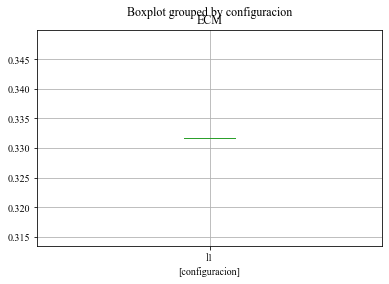

{'penalty': 'l1', 'C': 1e-05}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


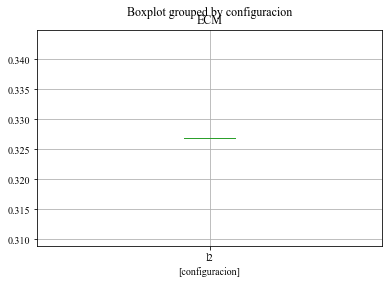

{'penalty': 'l2', 'C': 1e-05}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


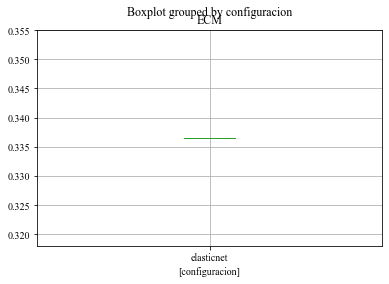

{'penalty': 'elasticnet', 'C': 1e-05}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


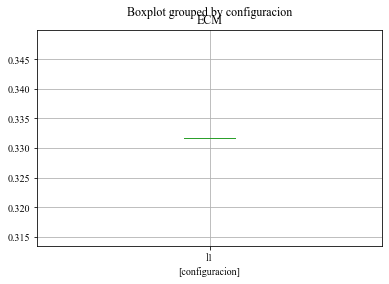

{'penalty': 'l1', 'C': 0.0001}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


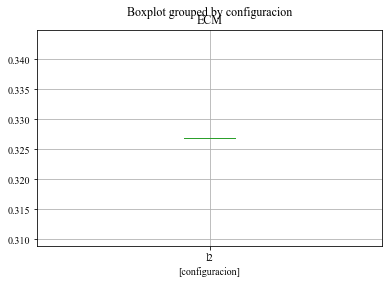

{'penalty': 'l2', 'C': 0.0001}


KeyboardInterrupt: 

In [877]:
ecm_rl=evalua_config_1('regresion_logistica',[pow(10,-5),pow(10,-4),pow(10,-3),pow(10,-1),pow(10,-1),pow(10,0),pow(10,1),pow(10,2),pow(10,3),pow(10,4),pow(10,5)],10,X,y)

In [951]:
ecm_rl.head(30)

,Modelo,Matriz de confusión,La presición del modelo es,AUC,ECM,grado,configuracion
0,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,l1
1,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,l2
2,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,elasticnet


In [ ]:
# No llegamos a completar este punto. 

#### 7) 

Encontramos que todos los métodos de regularizacion obtienen el mínimo ecm cuando lambda es igual a 0.2. El ECM que obtienen es igual en los tres casos. Notamos que este resultado es extraño. 

C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


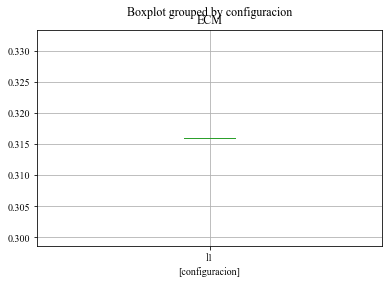

{'penalty': 'l1', 'C': 0.02}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


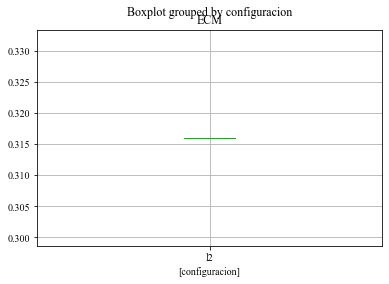

{'penalty': 'l2', 'C': 0.02}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


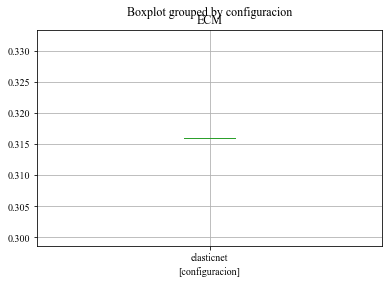

{'penalty': 'elasticnet', 'C': 0.02}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


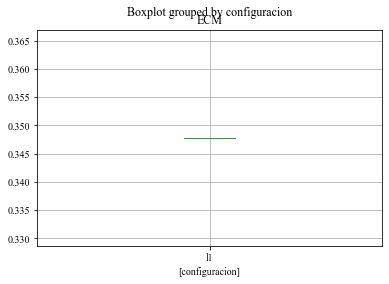

{'penalty': 'l1', 'C': 2e-06}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


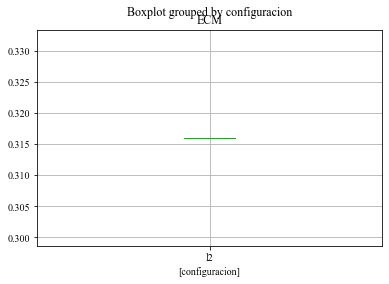

{'penalty': 'l2', 'C': 2e-06}


<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


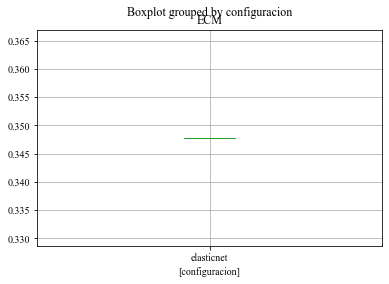

{'penalty': 'elasticnet', 'C': 2e-06}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


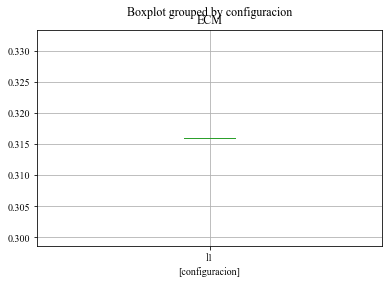

{'penalty': 'l1', 'C': 0.5}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


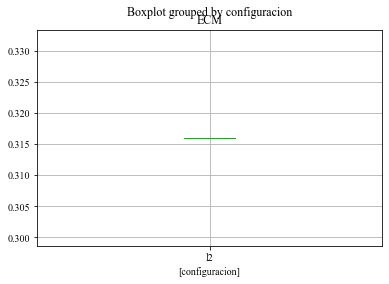

{'penalty': 'l2', 'C': 0.5}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


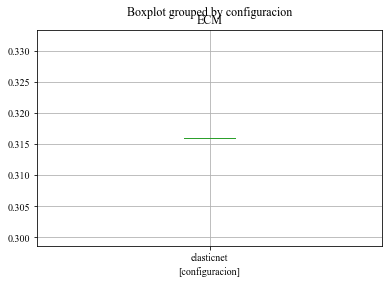

{'penalty': 'elasticnet', 'C': 0.5}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


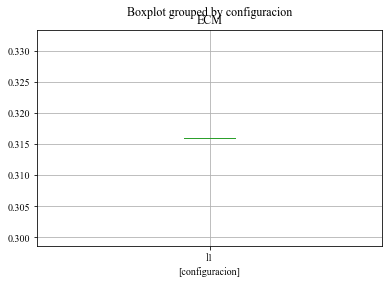

{'penalty': 'l1', 'C': 2}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


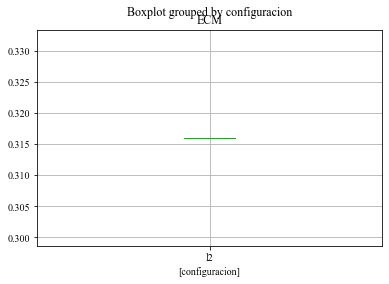

{'penalty': 'l2', 'C': 2}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


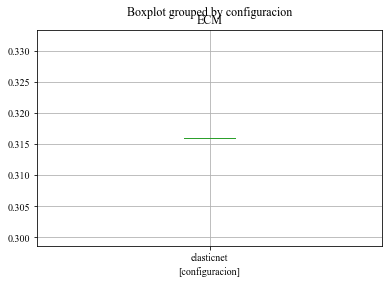

{'penalty': 'elasticnet', 'C': 2}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


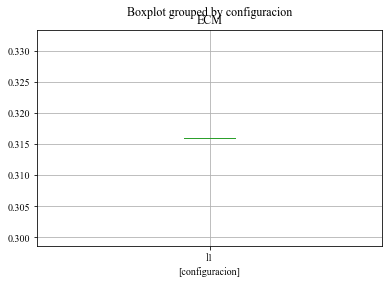

{'penalty': 'l1', 'C': 0.7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


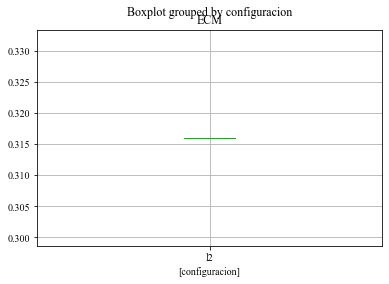

{'penalty': 'l2', 'C': 0.7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


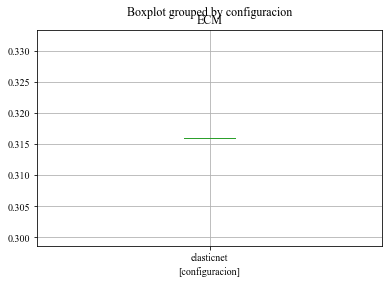

{'penalty': 'elasticnet', 'C': 0.7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


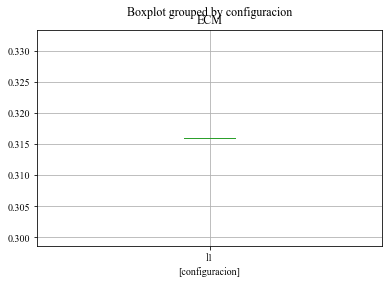

{'penalty': 'l1', 'C': 7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


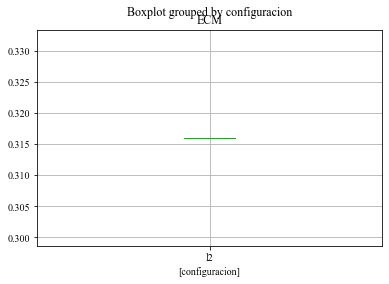

{'penalty': 'l2', 'C': 7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


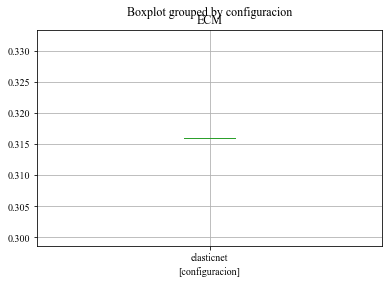

{'penalty': 'elasticnet', 'C': 7}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


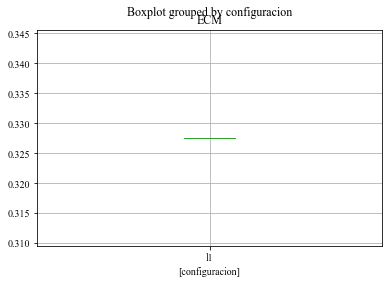

{'penalty': 'l1', 'C': 4e-05}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


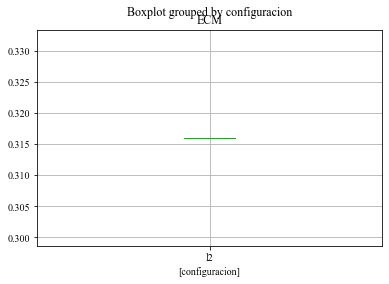

{'penalty': 'l2', 'C': 4e-05}


C:\Users\Abi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
<ipython-input-857-5f94396f036f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[modelo,matriz_confusion,prec,auc,ecm]])


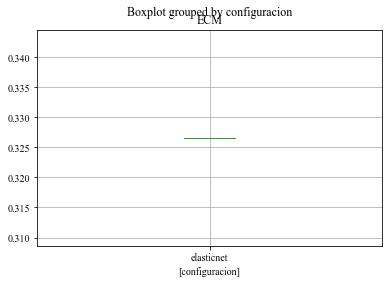

{'penalty': 'elasticnet', 'C': 4e-05}


<ipython-input-874-5aff2d4833dc>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecm_rl_l1['ECM'] = pd.to_numeric(ecm_rl_l1['ECM'])
<ipython-input-874-5aff2d4833dc>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecm_rl_l2['ECM'] = pd.to_numeric(ecm_rl_l2['ECM'])
<ipython-input-874-5aff2d4833dc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [886]:
# Observamos la matriz del punto 2. El método de regularización que funcionó mejor fue: 

ecm_punto_7=evalua_config_1('regresion_logistica',[0.2,0.000002,0.5,2,0.7,7,0.00004],2,X,y)






In [950]:
ecm_punto_7.head(30)

,Modelo,Matriz de confusión,La presición del modelo es,AUC,ECM,grado,configuracion
0,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,l1
1,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,l2
2,regresion_logistica,"[[264, 16], [111, 24]]",0.693976,0.560317,0.306024,0.2,elasticnet


#### 8) 

A partir de los resultados del punto 2 encontramos que el modelo que mejor predice es analisis discriminante. Este modelo presenta un mejor desempeño en todas las medidas consideradas. El error cuadrático medio obtenido con
vecinos cercanos es 0.199037, mientras que el de los demás modelos es mayor a 0.2.
Con respecto al AUC, este modelo es aquel que obtiene un mayor valor. Por último, con
respecto a la presición del modelo también podemos decir que obtiene un valor mayor
a los modelos de regresion lineal, analisis discriminante y regresion logistica. 	

#### 9)

Con el método que seleccionó, predigan qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?



In [917]:
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train, y_train)

In [932]:
y_pred_lda_2=lda.predict(no_respondieron)

In [933]:
# Aplicamos la regla de bayes
y_pred_lda_2=np.where(y_pred_lda_2>=0.5, 1, y_pred_lda_2)
y_pred_lda_2=np.where(y_pred_lda_2<0.5, 0, y_pred_lda_2)

In [935]:
#Contamos la cantidad de pobres predecidos en la base "no respondieron"
y_pred_lda_2 = pd.Series(y_pred_lda_2.tolist())
y_pred_lda_2.value_counts()

0    1328
1      62
dtype: int64

 Con análisis discriminante predecimos que hay 62 personas pobres de una muestra total de 1390 observaciones, es decir, que aproximadamente el 5% de esta muestra es pobre. Al igual que en el trabajo práctico 2 encontramos un porcentaje bajo de pobres. Creemos que esto puede tener sentido si, por ejemplo, aquellas personas con más dinero son las que deciden no dar información sobre sus ingresos. 